#Importo Librerie

In [1]:
import pandas as pd
import numpy as np
!pip install scikit-learn
!pip install surprise
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from surprise import SVD
from surprise import Dataset, Reader
import matplotlib.pyplot as plt


#Carico csv e creazione dataFrame

Creo due dataFrame movies e ratings

In [2]:
#Creo due dataFrame movies e ratings

movies = pd.read_csv(r'/content/movies.csv', sep=',', names=['movieId', 'title', 'genres'],  encoding="Latin1")
movies.drop(['genres'], axis=1, inplace=True)

# pd.read_csv: Utilizza la funzione read_csv della libreria pandas per leggere i dati da un file CSV.
# "movies.csv": Specifica il percorso del file CSV.
# sep=',': Specifica che il separatore tra le colonne nel file CSV è la virgola.
# names=['movieId', 'title', 'genres']: Assegna i nomi alle colonne del DataFrame.
# encoding="Latin1": Specifica l'encoding del file. Latin1 è comune per gestire caratteri speciali in testi in lingue europee.

ratings = pd.read_csv(r'/content/ratings.csv', sep=',', names =['userId', 'movieId', 'rating', 'timestamp'], encoding = "Latin1")
ratings.drop(['timestamp'], axis=1, inplace=True)

Visualizzo movies

In [3]:
movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


visualizzo ratings

In [4]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


Effettuo la media dei voti per ogni singolo user

In [5]:
mean = ratings.groupby(by="userId",as_index=False)['rating'].mean()
mean.head()

,userId,rating
0,1,4.366379
1,2,3.948276
2,3,2.435897
3,4,3.555556
4,5,3.636364


#Divido in test set e train set

In [6]:
from sklearn.model_selection import train_test_split
# Assuming 'ratings' is your original DataFrame
RANDOM_SEED=42
train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=RANDOM_SEED)

In [7]:
print("Training set size: {:d} instances".format(len(train_df)))
print("Test set size: {:d} instances".format(len(test_df)))

Training set size: 80668 instances
Test set size: 20168 instances


In [8]:
train_df.head()

,userId,movieId,rating
80568,509,7347,3.0
50582,326,71462,4.0
8344,57,2115,3.0
99603,610,1127,4.0
71701,462,2409,2.0


In [9]:
test_df.head()

,userId,movieId,rating
67037,432,77866,4.5
42175,288,474,3.0
93850,599,4351,3.0
6187,42,2987,4.0
12229,75,1610,4.0


#Crea una matrice utente-film (user-item matrix) per il training set

In [10]:
user_item_matrix = train_df.pivot(index='userId', columns='movieId', values='rating')

In [11]:
user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Creazione del gruppo random

Seleziono 5 utenti random tramite i loro id

In [12]:
# Seleziona casualmente 5 utenti dal trainset
#selected_users = user_item_matrix.sample(5).index
#selected_users
selected_users = [45, 555, 426, 364, 114]

Creo un gruppo di utenti quindi dai 5 id che ho

In [13]:
# Crea un gruppo di utenti
group = user_item_matrix.loc[selected_users]
group

movieId,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
45,4.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
555,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Previsione dei rating di un movie che non è stato visto da nessuno dei membri del gruppo

Tra tutti i film che non sono stati visti da nessuno dei 5 utenti, ne sceglie 1 casuale

In [14]:
import random

#Crea un set contenente tutti i movieId disponibili
all_movie_ids = set(user_item_matrix.columns)

# Estrai i movieId che nessun utente nel gruppo ha visto
unseen_movie_for_group = all_movie_ids.copy()

for user_ratings in group.itertuples(index=False):
    seen_movies = {idx + 1 for idx, rating in enumerate(user_ratings) if not pd.isna(rating)}
    unseen_movie_for_group -= seen_movies

# Seleziona casualmente un movieId tra quelli non visti
random_unseen_movie_id = random.choice(list(unseen_movie_for_group))

# Stampa il movieId scelto casualmente
print("MovieId non visto nel gruppo:", random_unseen_movie_id)


MovieId non visto nel gruppo: 143367


Visualizzazione della matrice con il movie non visto e i 5 utenti

In [15]:
# Crea una nuova matrice con gli indici dei 5 userId e il movieId scelto casualmente
new_matrix = pd.DataFrame(index=selected_users, columns=[random_unseen_movie_id])

# Imposta tutti i valori della nuova matrice su NaN
new_matrix[:] = np.nan

# Stampa la nuova matrice
new_matrix.head()

,143367
45,NaN
555,NaN
426,NaN
364,NaN
114,NaN


In [16]:
# Stampare che ogni utente non ha visto il film con id di random_unseen_movie_id
#random_unseen_movie_id = user_item_matrix.columns[1]                             (PER TESTARE IL FUNZIONAMENTO)

unseen_movies = {user_id: random_unseen_movie_id for user_id in selected_users}

print("Unseen Movies:", unseen_movies)

# Create Surprise dataset and train the model
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(user_item_matrix.stack().reset_index(), reader)
trainset = data.build_full_trainset()

model = SVD()
model.fit(trainset)

# Predict ratings for the unseen movies
predicted_ratings = []
for user_id, unseen_movie_id in unseen_movies.items():
    prediction = model.predict(user_id, unseen_movie_id)
    predicted_ratings.append({
        'userId': user_id,
        'movieId': unseen_movie_id,
        'predicted_rating': prediction.est
    })

predicted_ratings_df = pd.DataFrame(predicted_ratings)

# Update the group DataFrame with predicted ratings
for index, row in predicted_ratings_df.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    predicted_rating = row['predicted_rating']
    group.at[user_id, movie_id] = predicted_rating

group.head()


Unseen Movies: {45: 143367, 555: 143367, 426: 143367, 364: 143367, 114: 143367}


movieId,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
45,4.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
555,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Per tutta la user-item matrix

In [17]:
# Create a group of users
group = user_item_matrix.loc[selected_users]

# Identify all unseen movies for each user in the group
unseen_movies = {}
for user_id, user_ratings in group.iterrows():
    unseen_movies[user_id] = user_ratings[user_ratings.isna()].index

# Create Surprise dataset and train the model
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(user_item_matrix.stack().reset_index(), reader)
trainset = data.build_full_trainset()

model = SVD(random_state=42)
model.fit(trainset)

# Predict ratings for all unseen movies
predicted_ratings = []
for user_id, unseen_movie_ids in unseen_movies.items():
    for unseen_movie_id in unseen_movie_ids:
        prediction = model.predict(user_id, unseen_movie_id)
        predicted_ratings.append({
            'userId': user_id,
            'movieId': unseen_movie_id,
            'predicted_rating': prediction.est
        })

predicted_ratings_df = pd.DataFrame(predicted_ratings)

# Update the group DataFrame with predicted ratings
for index, row in predicted_ratings_df.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    predicted_rating = row['predicted_rating']
    group.at[user_id, movie_id] = predicted_rating

group.head()


movieId,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
45,4.000000,3.627642,3.742113,3.110060,3.272522,4.142917,3.000000,3.669533,3.505153,3.640995,...,3.731959,4.116102,3.695348,3.683378,3.956927,4.057968,3.847292,3.937922,4.019761,3.684924
555,4.000000,3.248407,5.000000,2.965896,2.507333,3.880075,2.957847,2.582398,3.094254,3.547668,...,3.685503,3.264485,3.447040,3.341026,3.509677,3.794937,3.668116,3.312408,3.729667,3.252378
426,3.910316,3.326449,2.907968,3.154068,3.027966,3.732369,3.212350,2.595867,3.188173,3.789659,...,3.269816,3.241358,3.522295,3.922797,3.547408,3.174262,3.589531,3.320717,3.203322,3.552844
364,4.470403,3.697447,3.676554,3.521110,3.367973,4.399469,3.447131,3.658736,3.000000,3.937679,...,4.044527,3.890689,4.106532,4.093906,3.902275,3.754721,3.936878,3.927007,3.859471,4.120759
114,3.759710,2.982937,2.915390,2.753439,2.635371,3.515611,2.736496,2.689890,2.879802,3.075374,...,3.328601,3.055941,3.345030,3.270843,3.111263,3.065626,3.322510,3.154111,3.111401,3.060692


Calcolo RMSE

In [18]:
from surprise import accuracy

# Creare un oggetto Reader per specificare la scala delle valutazioni
reader = Reader(rating_scale=(1, 5))

# Caricare il testset da test_df utilizzando il modulo Dataset di Surprise
data = Dataset.load_from_df(test_df[['userId', 'movieId', 'rating']], reader)
testset = data.build_full_trainset().build_testset()

# Prevedere le valutazioni per il testset
test_predictions = model.test(testset)

# Calcolare l'RMSE
rmse = accuracy.rmse(test_predictions)
print("RMSE:", rmse)

RMSE: 0.8881
RMSE: 0.8880978924901524


# Per Ratings normalizzati

##pre operazioni di configurazione df e test/train set normalizzati

In [19]:
def normalize_table_by_user_mean(table):
    # Calcola la media dei voti per ogni utente
    user_means = table.mean(axis=1)

    # Sottrai la media dell'utente da ogni valore nella tabella
    normalized_table = table.sub(user_means, axis=0)

    return normalized_table

# Esempio di utilizzo con la tabella random_rows
normalized_table = normalize_table_by_user_mean(user_item_matrix)

# Stampa la tabella normalizzata
normalized_table

movieId,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.331606,NaN,-0.331606,NaN,NaN,-0.331606,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,-1.157002,NaN,NaN,NaN,NaN,NaN,-1.157002,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,-0.617820,-1.11782,-1.117820,NaN,NaN,NaN,NaN,NaN,NaN,0.882180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Uso lo stesso gruppo di prima ma con i valori normalizzati

In [20]:
import pandas as pd

# Supponiamo che 'ratings' sia il tuo DataFrame
# Assicurati che 'ratings' abbia le colonne 'userId', 'movieId' e 'rating'

# Calcola la media delle valutazioni per ciascun utente
user_avg_ratings = ratings.groupby('userId')['rating'].mean()

# Unisci la media delle valutazioni con il DataFrame originale
ratings_normalized = pd.merge(ratings, user_avg_ratings, on='userId', how='left', suffixes=('', '_avg'))

# Sottrai la media delle valutazioni di ciascun utente dalla valutazione originale
ratings_normalized['rating_normalized'] = ratings_normalized['rating'] - ratings_normalized['rating_avg']

# Elimina le colonne aggiuntive
ratings_normalized = ratings_normalized[['userId', 'movieId', 'rating_normalized']]

# Stampa il DataFrame risultante
ratings_normalized.head()


,userId,movieId,rating_normalized
0,1,1,-0.366379
1,1,3,-0.366379
2,1,6,-0.366379
3,1,47,0.633621
4,1,50,0.633621


In [21]:
from sklearn.model_selection import train_test_split
# Assuming 'ratings' is your original DataFrame
RANDOM_SEED=42
train_df_norm, test_df_norm = train_test_split(ratings_normalized, test_size=0.2, random_state=RANDOM_SEED)

In [22]:
# Crea lo stesso gruppo di prima
group_normalized = normalized_table.loc[selected_users]
group_normalized

movieId,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
45,0.089905,NaN,NaN,NaN,NaN,NaN,-0.910095,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
555,0.566596,NaN,1.566596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
import numpy as np
# Trova il valore più piccolo e il valore più grande nella matrice
min_value = np.nanmin(group_normalized)
max_value = np.nanmax(group_normalized)

print("Valore più piccolo nella matrice:", min_value)
print("Valore più grande nella matrice:", max_value)

Valore più piccolo nella matrice: -3.111111111111111
Valore più grande nella matrice: 1.5665961945031714


##Predizione con ratings normalizzati

In [24]:
# Identify all unseen movies for each user in the group_normalized
unseen_movies = {}
for user_id, user_ratings in group_normalized.iterrows():
    unseen_movies[user_id] = user_ratings[user_ratings.isna()].index

# Create Surprise dataset and train the model
reader = Reader(rating_scale=(min_value, max_value))
data = Dataset.load_from_df(normalized_table.stack().reset_index(), reader)
trainset = data.build_full_trainset()

model = SVD(random_state=42)
model.fit(trainset)

# Predict ratings for all unseen movies
predicted_ratings = []
for user_id, unseen_movie_ids in unseen_movies.items():
    for unseen_movie_id in unseen_movie_ids:
        prediction = model.predict(user_id, unseen_movie_id)
        predicted_ratings.append({
            'userId': user_id,
            'movieId': unseen_movie_id,
            'predicted_rating': prediction.est
        })

predicted_ratings_df = pd.DataFrame(predicted_ratings)

# Update the group_normalized DataFrame with predicted ratings
for index, row in predicted_ratings_df.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    predicted_rating = row['predicted_rating']
    group_normalized.at[user_id, movie_id] = predicted_rating

group_normalized.head()


movieId,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
45,0.089905,-0.256961,-0.147268,-0.787741,-0.648580,0.236554,-0.910095,-0.221673,-0.426395,-0.267193,...,-0.152848,0.243765,-0.187891,-0.206840,0.068026,0.182898,-0.042339,0.056514,0.136830,-0.199538
555,0.566596,-0.178469,1.566596,-0.484945,-0.989981,0.405374,-0.492669,-0.869479,-0.390252,0.078238,...,0.256042,-0.165797,0.024745,-0.095512,0.101485,0.370793,0.251542,-0.113288,0.292987,-0.172536
426,0.276206,-0.287412,-0.682153,-0.444769,-0.583353,0.139434,-0.405376,-0.997232,-0.454007,0.185558,...,-0.311471,-0.339382,-0.057015,0.333483,-0.036751,-0.414985,-0.006209,-0.258020,-0.376494,-0.034390
364,0.446305,-0.258816,-0.329282,-0.467989,-0.637368,0.389325,-0.538269,-0.304706,-1.200000,-0.073013,...,0.087394,-0.070892,0.143638,0.109982,-0.063923,-0.236665,-0.052961,-0.054135,-0.107520,0.141557
114,0.287631,-0.454724,-0.535946,-0.678204,-0.817220,0.071968,-0.708167,-0.742970,-0.590267,-0.378826,...,-0.097237,-0.365557,-0.078558,-0.151204,-0.311703,-0.357469,-0.101674,-0.266207,-0.313295,-0.359980


###Calcolo RMSE

In [25]:
from surprise import accuracy

# Creare un oggetto Reader per specificare la scala delle valutazioni
reader = Reader(rating_scale=(min_value, max_value))

# Caricare il testset da test_df utilizzando il modulo Dataset di Surprise
data = Dataset.load_from_df(test_df_norm[['userId', 'movieId', 'rating_normalized']], reader)
testset = data.build_full_trainset().build_testset()

# Prevedere le valutazioni per il testset
test_predictions = model.test(testset)

# Calcolare l'RMSE
rmse = accuracy.rmse(test_predictions)
print("RMSE:", rmse)

RMSE: 0.8822
RMSE: 0.8821787434639216


#Funzioni ricorrenti

Funzione che dati movie id e un dataframe, restituisce il titolo associato all'id nel df

In [26]:
def get_titles_from_ids(result_id, movies):
    titles = [movies.loc[movies['movieId'] == id_, 'title'].values[0] for id_ in result_id]
    return titles

Generatore casuale di 10 id dalle colonne di un df

In [27]:
def generate_random_movie_list(ratings):
    # Estrai casualmente 10 ID di film dalla lista di colonne del DataFrame
    movie_ids = ratings.columns.tolist()
    random_movie_list = random.sample(movie_ids, 10)
    return random_movie_list

Funzione che confronta se due liste sono uguali

In [28]:
def confronta_liste(lista1, lista2):
    if lista1 == lista2:
        print("Le liste sono uguali.")
    else:
        print("Le liste non sono uguali.")

#Average

La strategia prevede per ogni item di calcolare la media dei voti assegnata da tutti gli user. La media viene salvata in una nuova colonna, Ho applicato la stretegia sia al df normalizzato che non normalizzato, confrontando i risultati.

## Su df non Normalizzato

In [29]:
def order_items_by_average(ratings):
    # Copia il DataFrame originale per non alterare i dati originali
    ratings_copy = ratings.copy()

    # Calcola la media per ogni item (sull'asse delle righe)
    item_means = ratings_copy.mean(axis=1)

    # Arrotonda i valori delle medie a due cifre decimali
    item_means_rounded = item_means.round(2)

    # Aggiunge una nuova colonna "average" al DataFrame con le medie arrotondate
    ratings_copy['average'] = item_means_rounded

    # Stampa per visualizzare la tabella
    print(ratings_copy)

    # Ordina gli item in base alla colonna 'average' in ordine decrescente
    sorted_items = ratings_copy.sort_values(by='average', ascending=False)

    # Crea la lista risultato
    result_list = sorted_items.index.tolist()

    return result_list[:10]


# Esempio di utilizzo
result1 = order_items_by_average(group.T)
print(result1)


userId         45       555       426       364       114  average
movieId                                                           
1        4.000000  4.000000  3.910316  4.470403  3.759710     4.03
2        3.627642  3.248407  3.326449  3.697447  2.982937     3.38
3        3.742113  5.000000  2.907968  3.676554  2.915390     3.65
4        3.110060  2.965896  3.154068  3.521110  2.753439     3.10
5        3.272522  2.507333  3.027966  3.367973  2.635371     2.96
...           ...       ...       ...       ...       ...      ...
193581   4.057968  3.794937  3.174262  3.754721  3.065626     3.57
193583   3.847292  3.668116  3.589531  3.936878  3.322510     3.67
193585   3.937922  3.312408  3.320717  3.927007  3.154111     3.53
193587   4.019761  3.729667  3.203322  3.859471  3.111401     3.58
193609   3.684924  3.252378  3.552844  4.120759  3.060692     3.53

[8983 rows x 6 columns]
[1197, 356, 2858, 318, 50, 1213, 2329, 2571, 1035, 858]


In [30]:
result_id = result1
result_id

[1197, 356, 2858, 318, 50, 1213, 2329, 2571, 1035, 858]

In [31]:
# Passo da id a titoli
titles = get_titles_from_ids(result_id, movies)
print(titles)


['Princess Bride, The (1987)', 'Forrest Gump (1994)', 'American Beauty (1999)', 'Shawshank Redemption, The (1994)', 'Usual Suspects, The (1995)', 'Goodfellas (1990)', 'American History X (1998)', 'Matrix, The (1999)', 'Sound of Music, The (1965)', 'Godfather, The (1972)']


Stampo nome e id film raccomandato con strategia average

In [32]:
print(f"Il movie raccomandato è {get_titles_from_ids(result_id[:1], movies)} con id {result_id[0]}")

Il movie raccomandato è ['Princess Bride, The (1987)'] con id 1197


###Valutazioni

Genero una lista casuale di 10 movie id

In [33]:
# Esempio di utilizzo
random_movie_list = generate_random_movie_list(user_item_matrix)
print(random_movie_list)

[44759, 2774, 100810, 1225, 100737, 5423, 8610, 188833, 5296, 102378]


Confronto l'average del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [34]:
def average_of_item_by_id(ratings, item_id):
    # Verifica se l'ID dell'item è presente nel DataFrame
    if item_id in ratings.index:
        # Calcola la media della riga corrispondente all'item con ID specificato
        item_average = ratings.loc[item_id].mean()
        return item_average

# Esempio di utilizzo

print(f"Media dell'movie con ID {result_id[0]} scelto dal sistema: {average_of_item_by_id(group.T, result_id[0])}")
print(f"Media dell'movie con ID {random_movie_list[0]} scelto random: {average_of_item_by_id(group.T, random_movie_list[0])}")

if average_of_item_by_id(group.T, result_id[0]) >= average_of_item_by_id(group.T, random_movie_list[0]):
  print(f"La strategia ha scelto un movie con average migliore di quello casuale")
else: print(f"La strategia poteva scegliere un item migliore")

Media dell'movie con ID 1197 scelto dal sistema: 4.634030395531342
Media dell'movie con ID 44759 scelto random: 3.263172988871659
La strategia ha scelto un movie con average migliore di quello casuale


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [35]:
def averages_of_items_by_ids(ratings, item_ids):

    # Calcola le medie delle righe corrispondenti agli item con ID specificati
    item_averages = [ratings.loc[item_id].mean() for item_id in item_ids]

    return item_averages

# Esempio di utilizzo
averages_top = averages_of_items_by_ids(group.T, result_id)
averages_casual = averages_of_items_by_ids(group.T, random_movie_list)

# Stampa solo gli average in un'unica istruzione
print(f"Medie dei top 10 movie id suggeriti:\n{averages_top}")
print(f"Medie movie id casuali:\n{averages_casual}")


Medie dei top 10 movie id suggeriti:
[4.634030395531342, 4.588842785020575, 4.583932670514737, 4.582667389999214, 4.56850115319933, 4.519719510701085, 4.507319080704617, 4.493437822953019, 4.490740029196708, 4.482618636587733]
Medie movie id casuali:
[3.263172988871659, 3.5950155744081607, 3.464358070282418, 4.060613602357689, 3.5172212661879656, 3.493317183872552, 3.5900910002737234, 3.6620927109529986, 3.189738761969317, 3.432137696358269]


In [36]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top >= casual for top, casual in zip(averages_top, averages_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


## Su df normalizzato

In [37]:
# Esempio di utilizzo
result1n = order_items_by_average(group_normalized.T)
print(result1n)

userId         45       555       426       364       114  average
movieId                                                           
1        0.089905  0.566596  0.276206  0.446305  0.287631     0.33
2       -0.256961 -0.178469 -0.287412 -0.258816 -0.454724    -0.29
3       -0.147268  1.566596 -0.682153 -0.329282 -0.535946    -0.03
4       -0.787741 -0.484945 -0.444769 -0.467989 -0.678204    -0.57
5       -0.648580 -0.989981 -0.583353 -0.637368 -0.817220    -0.74
...           ...       ...       ...       ...       ...      ...
193581   0.182898  0.370793 -0.414985 -0.236665 -0.357469    -0.09
193583  -0.042339  0.251542 -0.006209 -0.052961 -0.101674     0.01
193585   0.056514 -0.113288 -0.258020 -0.054135 -0.266207    -0.13
193587   0.136830  0.292987 -0.376494 -0.107520 -0.313295    -0.07
193609  -0.199538 -0.172536 -0.034390  0.141557 -0.359980    -0.12

[8983 rows x 6 columns]
[1197, 356, 2858, 318, 50, 1213, 2329, 2571, 1035, 912]


In [38]:
result_id_normalized = result1n
result_id_normalized

[1197, 356, 2858, 318, 50, 1213, 2329, 2571, 1035, 912]

In [39]:
# Esempio di utilizzo
titles = get_titles_from_ids(result_id_normalized, movies)
print(titles)

['Princess Bride, The (1987)', 'Forrest Gump (1994)', 'American Beauty (1999)', 'Shawshank Redemption, The (1994)', 'Usual Suspects, The (1995)', 'Goodfellas (1990)', 'American History X (1998)', 'Matrix, The (1999)', 'Sound of Music, The (1965)', 'Casablanca (1942)']


In [40]:
confronta_liste(result_id, result_id_normalized)

Le liste non sono uguali.


###Valutazioni

Considero la stessa lista di id randomici

In [41]:
random_movie_list

[44759, 2774, 100810, 1225, 100737, 5423, 8610, 188833, 5296, 102378]

Confronto l'average del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [42]:
# Esempio di utilizzo

print(f"Media dell'movie con ID {result_id_normalized[0]} scelto dal sistema: {average_of_item_by_id(group_normalized.T, result_id_normalized[0])}")
print(f"Media dell'movie con ID {random_movie_list[0]} scelto random: {average_of_item_by_id(group_normalized.T, random_movie_list[0])}")

if average_of_item_by_id(group_normalized.T, result_id_normalized[0]) >= average_of_item_by_id(group_normalized.T, random_movie_list[0]):
  print(f"La strategia ha scelto un item con average migliore di quello casuale")
else: print(f"La strategia poteva scegliere un itmem migliore")

Media dell'movie con ID 1197 scelto dal sistema: 0.9556064489472617
Media dell'movie con ID 44759 scelto random: -0.39670303789814987
La strategia ha scelto un item con average migliore di quello casuale


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [43]:
def averages_of_items_by_ids(ratings, item_ids):

    # Calcola le medie delle righe corrispondenti agli item con ID specificati
    item_averages = [ratings.loc[item_id].mean() for item_id in item_ids]

    return item_averages

# Esempio di utilizzo
averages_top = averages_of_items_by_ids(group_normalized.T, result_id_normalized)
averages_casual = averages_of_items_by_ids(group_normalized.T, random_movie_list)

# Stampa solo gli average in un'unica istruzione
print(f"Medie dei top 10 movie id suggeriti:\n{averages_top}")
print(f"Medie movie id casuali:\n{averages_casual}")


Medie dei top 10 movie id suggeriti:
[0.9556064489472617, 0.9080584764255406, 0.9013972125396329, 0.8933655970934815, 0.8901749221397164, 0.8346886629742223, 0.8092162306837022, 0.8015904050035674, 0.8028462880347365, 0.787040653414506]
Medie movie id casuali:
[-0.39670303789814987, -0.06065653973551881, -0.202937390584559, 0.3699700875617533, -0.13680114567916055, -0.17009760422613138, -0.06649642756551397, 0.008084036608447632, -0.4812648531187576, -0.22174332514416065]


In [44]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top >= casual for top, casual in zip(averages_top, averages_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


#Average Without Misery

Questa strategia si basa sul calcolo della media dei rating di ogni singolo item, ma senza considerare gli item che hanno uno score sotto una determinata soglia. Gli item il cui voto non supera la soglia nella matrice hanno valore NaN. Ho applicato questa strategia sia al df normalizzato che normale

## Su df non Normalizzato





In [45]:
def order_items_by_average_with_threshold(ratings, threshold):
    # Copia il DataFrame originale per non alterare i dati originali
    ratings_copy = ratings.copy()

    # Applica la soglia alle valutazioni
    ratings_copy[ratings_copy < threshold] = pd.NA

    # Trova item con almeno una valutazione al di sotto della soglia
    items_below_threshold = ratings_copy[ratings_copy.isna().any(axis=1)].index.tolist()

    # Calcola la media per ogni item
    item_means = ratings_copy.mean(axis=1)

    # Arrotonda i valori delle medie a una cifra decimale
    item_means_rounded = item_means.round(2)

    # Aggiunge una nuova colonna "average" al DataFrame con le medie arrotondate
    ratings_copy['average'] = item_means_rounded

    # Stampa per visualizzare la tabella
    print(ratings_copy)

    # Escludi gli item con almeno una valutazione al di sotto della soglia
    sorted_items = item_means[~item_means.index.isin(items_below_threshold)].sort_values(ascending=False)

    # Crea la lista risultato
    result_list = sorted_items.index.tolist()

    return result_list[:10]

# Esempio di utilizzo

threshold = 3.5
result2 = order_items_by_average_with_threshold(group.T, threshold)
print(result2)


userId         45       555       426       364      114  average
movieId                                                          
1        4.000000  4.000000  3.910316  4.470403  3.75971     4.03
2        3.627642       NaN       NaN  3.697447      NaN     3.66
3        3.742113  5.000000       NaN  3.676554      NaN     4.14
4             NaN       NaN       NaN  3.521110      NaN     3.52
5             NaN       NaN       NaN       NaN      NaN      NaN
...           ...       ...       ...       ...      ...      ...
193581   4.057968  3.794937       NaN  3.754721      NaN     3.87
193583   3.847292  3.668116  3.589531  3.936878      NaN     3.76
193585   3.937922       NaN       NaN  3.927007      NaN     3.93
193587   4.019761  3.729667       NaN  3.859471      NaN     3.87
193609   3.684924       NaN  3.552844  4.120759      NaN     3.79

[8983 rows x 6 columns]
[1197, 356, 2858, 318, 50, 1213, 2329, 2571, 1035, 858]


In [46]:
result_id = result2
result_id

[1197, 356, 2858, 318, 50, 1213, 2329, 2571, 1035, 858]

In [47]:
# Esempio di utilizzo
titles = get_titles_from_ids(result_id, movies)
print(titles)


['Princess Bride, The (1987)', 'Forrest Gump (1994)', 'American Beauty (1999)', 'Shawshank Redemption, The (1994)', 'Usual Suspects, The (1995)', 'Goodfellas (1990)', 'American History X (1998)', 'Matrix, The (1999)', 'Sound of Music, The (1965)', 'Godfather, The (1972)']


###Valutazioni

Considero la stessa lista di id randomici

In [48]:
random_movie_list

[44759, 2774, 100810, 1225, 100737, 5423, 8610, 188833, 5296, 102378]

Confronto l'average del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [49]:
def average_of_item_by_id(ratings, item_id):
    # Verifica se l'ID dell'item è presente nel DataFrame
    if item_id in ratings.index:
        # Calcola la media della riga corrispondente all'item con ID specificato
        item_average = ratings.loc[item_id].mean()
        return item_average

# Esempio di utilizzo

print(f"Media dell'movie con ID {result_id[0]} scelto dal sistema: {average_of_item_by_id(group.T, result_id[0])}")
print(f"Media dell'movie con ID {random_movie_list[0]} scelto random: {average_of_item_by_id(group.T, random_movie_list[0])}")

threshold = 3.5

if average_of_item_by_id(group.T, random_movie_list[0]) < threshold:
    print("L'elemento ha un average sotto soglia, quindi non verrebbe preso in considerazione.")
elif average_of_item_by_id(group.T, result_id[0]) >= average_of_item_by_id(group.T, random_movie_list[0]):
    print("La strategia ha scelto un item con average migliore di quello casuale.")
else:
    print("La strategia poteva scegliere un item migliore.")

Media dell'movie con ID 1197 scelto dal sistema: 4.634030395531342
Media dell'movie con ID 44759 scelto random: 3.263172988871659
L'elemento ha un average sotto soglia, quindi non verrebbe preso in considerazione.


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [50]:
def averages_of_items_by_ids(ratings, item_ids):

    # Calcola le medie delle righe corrispondenti agli item con ID specificati
    item_averages = [ratings.loc[item_id].mean() for item_id in item_ids]

    return item_averages

# Esempio di utilizzo
averages_top = averages_of_items_by_ids(group.T, result_id)
averages_casual = averages_of_items_by_ids(group.T, random_movie_list)

# Stampa solo gli average in un'unica istruzione
print(f"Medie dei top 10 movie id suggeriti:\n{averages_top}")
print(f"Medie movie id casuali:\n{averages_casual}")


Medie dei top 10 movie id suggeriti:
[4.634030395531342, 4.588842785020575, 4.583932670514737, 4.582667389999214, 4.56850115319933, 4.519719510701085, 4.507319080704617, 4.493437822953019, 4.490740029196708, 4.482618636587733]
Medie movie id casuali:
[3.263172988871659, 3.5950155744081607, 3.464358070282418, 4.060613602357689, 3.5172212661879656, 3.493317183872552, 3.5900910002737234, 3.6620927109529986, 3.189738761969317, 3.432137696358269]


In [51]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top >= casual for top, casual in zip(averages_top, averages_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


## Su df Normalizzato

In [52]:
group_normalized.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
45,0.089905,-0.256961,-0.147268,-0.787741,-0.648580,0.236554,-0.910095,-0.221673,-0.426395,-0.267193,...,-0.152848,0.243765,-0.187891,-0.206840,0.068026,0.182898,-0.042339,0.056514,0.136830,-0.199538
555,0.566596,-0.178469,1.566596,-0.484945,-0.989981,0.405374,-0.492669,-0.869479,-0.390252,0.078238,...,0.256042,-0.165797,0.024745,-0.095512,0.101485,0.370793,0.251542,-0.113288,0.292987,-0.172536
426,0.276206,-0.287412,-0.682153,-0.444769,-0.583353,0.139434,-0.405376,-0.997232,-0.454007,0.185558,...,-0.311471,-0.339382,-0.057015,0.333483,-0.036751,-0.414985,-0.006209,-0.258020,-0.376494,-0.034390
364,0.446305,-0.258816,-0.329282,-0.467989,-0.637368,0.389325,-0.538269,-0.304706,-1.200000,-0.073013,...,0.087394,-0.070892,0.143638,0.109982,-0.063923,-0.236665,-0.052961,-0.054135,-0.107520,0.141557
114,0.287631,-0.454724,-0.535946,-0.678204,-0.817220,0.071968,-0.708167,-0.742970,-0.590267,-0.378826,...,-0.097237,-0.365557,-0.078558,-0.151204,-0.311703,-0.357469,-0.101674,-0.266207,-0.313295,-0.359980


In [53]:
# Stessa strategia ma su df normalizzato
threshold = 0.3
result2n = order_items_by_average_with_threshold(group_normalized.T, threshold)
print(result2n)


userId   45       555  426       364  114  average
movieId                                           
1       NaN  0.566596  NaN  0.446305  NaN     0.51
2       NaN       NaN  NaN       NaN  NaN      NaN
3       NaN  1.566596  NaN       NaN  NaN     1.57
4       NaN       NaN  NaN       NaN  NaN      NaN
5       NaN       NaN  NaN       NaN  NaN      NaN
...      ..       ...  ...       ...  ...      ...
193581  NaN  0.370793  NaN       NaN  NaN     0.37
193583  NaN       NaN  NaN       NaN  NaN      NaN
193585  NaN       NaN  NaN       NaN  NaN      NaN
193587  NaN       NaN  NaN       NaN  NaN      NaN
193609  NaN       NaN  NaN       NaN  NaN      NaN

[8983 rows x 6 columns]
[1197, 356, 2858, 318, 50, 1213, 2329, 912, 750, 608]


In [54]:
result_id_normalized = result2n
result_id_normalized

[1197, 356, 2858, 318, 50, 1213, 2329, 912, 750, 608]

In [55]:
# Associo il titolo agli id
titles = get_titles_from_ids(result_id_normalized, movies)
print(titles)


['Princess Bride, The (1987)', 'Forrest Gump (1994)', 'American Beauty (1999)', 'Shawshank Redemption, The (1994)', 'Usual Suspects, The (1995)', 'Goodfellas (1990)', 'American History X (1998)', 'Casablanca (1942)', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)', 'Fargo (1996)']


In [56]:
confronta_liste(result_id, result_id_normalized)

Le liste non sono uguali.


###Valutazioni

Considero la stessa lista di id randomici

In [57]:
random_movie_list

[44759, 2774, 100810, 1225, 100737, 5423, 8610, 188833, 5296, 102378]

Confronto l'average del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [58]:

# Esempio di utilizzo

print(f"Media dell'movie con ID {result_id_normalized[0]} scelto dal sistema: {average_of_item_by_id(normalized_table.T, result_id_normalized[0])}")
print(f"Media dell'movie con ID {random_movie_list[0]} scelto random: {average_of_item_by_id(normalized_table.T, random_movie_list[0])}")

threshold = 0.6

if average_of_item_by_id(normalized_table.T, random_movie_list[0]) < threshold:
    print("L'elemento ha un average sotto soglia, quindi non verrebbe preso in considerazione.")
elif average_of_item_by_id(normalized_table.T, result_id_normalized[0]) >= average_of_item_by_id(normalized_table.T, random_movie_list[0]):
    print("La strategia ha scelto un item con average migliore di quello casuale.")
else:
    print("La strategia poteva scegliere un item migliore.")

Media dell'movie con ID 1197 scelto dal sistema: 0.634559353371288
Media dell'movie con ID 44759 scelto random: -1.7140432627666025
L'elemento ha un average sotto soglia, quindi non verrebbe preso in considerazione.


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [59]:
# Esempio di utilizzo
averages_top = averages_of_items_by_ids(normalized_table.T, result_id_normalized)
averages_casual = averages_of_items_by_ids(normalized_table.T, random_movie_list)

# Stampa solo gli average in un'unica istruzione
print(f"Medie dei top 10 movie id suggeriti:\n{averages_top}")
print(f"Medie movie id casuali:\n{averages_casual}")


Medie dei top 10 movie id suggeriti:
[0.634559353371288, 0.49859105492756595, 0.40664689648246055, 0.7383196148442617, 0.5970220389173434, 0.6103379515002016, 0.5291360571881351, 0.6805258421352189, 0.6829350872423546, 0.47291158954171486]
Medie movie id casuali:
[-1.7140432627666025, -0.5059171597633134, -0.9598247956074455, 0.5638471923679059, -0.04661016949152552, -0.4458187504877624, 0.10521688159437259, 0.7381615598885793, -0.5976541951178795, -0.4192670492022792]


In [60]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top >= casual for top, casual in zip(averages_top, averages_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 9/10


#Least Misery

Strategia che prevede la creazione di una riga di ratings con il minimo dei rating individuali per ogni item. Gli item sono selezionati in base all’ordine di rating di questa nuova riga, prima l’item con indice più alto e successivamente a descrescere.

##Su df non Normalizzato

In [61]:
def order_items_by_least_misery(random_rows):
    # Copia il DataFrame originale per non alterare i dati originali
    random_rows_copy = random_rows.copy()

    # Calcolare il voto minore per ogni ItemId tra le tre persone
    min_scores = random_rows_copy.min(axis=0)

    # Trovare gli ItemId con lo stesso voto minimo
    equal_min_scores = min_scores[min_scores.duplicated(keep=False)].index.tolist()

    # Aggiungere la riga "Minimo" al DataFrame con il rating minore corrispondente ad ogni ItemId
    random_rows_copy.loc['Minimo'] = min_scores

    # Stampa per visualizzare la tabella
    print(random_rows_copy)

    # Creare la lista risultato
    result_list = []

 # Aggiungere gli ItemId alla lista in ordine decrescente
    for item in min_scores.index:
            result_list.append(item)

    # Ordinare la lista risultato in base all'ordinamento di sorted_items
    sorted_items = min_scores.sort_values(ascending=False)
    result_list.sort(key=lambda x: sorted_items.index.get_loc(x))

    # Ordinare la lista risultato in base all'ordinamento di sorted_items
    sorted_items = min_scores.sort_values(ascending=False)
    result_list.sort(key=lambda x: sorted_items.index.get_loc(x))

    return result_list[:10]

# Esempio di utilizzo

result3 = order_items_by_least_misery(group)
print(result3)


movieId    1         2         3         4         5         6         7       \
userId                                                                          
45       4.000000  3.627642  3.742113  3.110060  3.272522  4.142917  3.000000   
555      4.000000  3.248407  5.000000  2.965896  2.507333  3.880075  2.957847   
426      3.910316  3.326449  2.907968  3.154068  3.027966  3.732369  3.212350   
364      4.470403  3.697447  3.676554  3.521110  3.367973  4.399469  3.447131   
114      3.759710  2.982937  2.915390  2.753439  2.635371  3.515611  2.736496   
Minimo   3.759710  2.982937  2.907968  2.753439  2.507333  3.515611  2.736496   

movieId    8         9         10      ...    191005    193565    193571  \
userId                                 ...                                 
45       3.669533  3.505153  3.640995  ...  3.731959  4.116102  3.695348   
555      2.582398  3.094254  3.547668  ...  3.685503  3.264485  3.447040   
426      2.595867  3.188173  3.789659  ...  3.2

In [62]:
result_id = result3
result_id

[527, 1262, 750, 898, 50, 4973, 2329, 1267, 1204, 318]

In [63]:
# Da id a Titolo
titles = get_titles_from_ids(result_id, movies)
print(titles)


["Schindler's List (1993)", 'Great Escape, The (1963)', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)', 'Philadelphia Story, The (1940)', 'Usual Suspects, The (1995)', "Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)", 'American History X (1998)', 'Manchurian Candidate, The (1962)', 'Lawrence of Arabia (1962)', 'Shawshank Redemption, The (1994)']


###Valutazioni

Considero la stessa lista di id randomici

In [64]:
random_movie_list

[44759, 2774, 100810, 1225, 100737, 5423, 8610, 188833, 5296, 102378]

Confronto la strategia sul primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [65]:
def min_of_item_by_id(ratings, item_id):
        # Calcola minimo della riga corrispondente all'item con ID specificato
        item_min = ratings.loc[item_id].min()
        return item_min

# Esempio di utilizzo

print(f"Punteggio dell'movie con ID con strategia Least Misery {result_id[0]} scelto dal sistema: {min_of_item_by_id(group.T, result_id[0])}")
print(f"Punteggio dell'movie con ID strategia Least Misery {random_movie_list[0]} scelto random: {min_of_item_by_id(group.T, random_movie_list[0])}")

if min_of_item_by_id(group.T, result_id[0]) >= min_of_item_by_id(group.T, random_movie_list[0]):
    print("La strategia ha scelto un item con punteggio migliore di quello casuale.")
else:
    print("La strategia poteva scegliere un item migliore.")

Punteggio dell'movie con ID con strategia Least Misery 527 scelto dal sistema: 4.118421250929159
Punteggio dell'movie con ID strategia Least Misery 44759 scelto random: 2.7784485457691273
La strategia ha scelto un item con punteggio migliore di quello casuale.


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [66]:
def min_of_items_by_ids(ratings, item_ids):

    # Calcola i punteggi delle righe corrispondenti agli item con ID specificati
    item_mins = [ratings.loc[item_id].min() for item_id in item_ids]

    return item_mins

# Esempio di utilizzo
min_top = min_of_items_by_ids(group.T, result_id)
min_casual = min_of_items_by_ids(group.T, random_movie_list)

# Stampa solo gli average in un'unica istruzione
print(f"Minimo dei top 10 movie id suggeriti:\n{min_top}")
print(f"Minimo movie id casuali:\n{min_casual}")


Minimo dei top 10 movie id suggeriti:
[4.118421250929159, 4.116030942989257, 4.088870703128184, 4.073096857049221, 4.039783070690077, 4.039029531722771, 4.035032211982876, 4.023580462098891, 4.015171342505109, 4.010660861690723]
Minimo movie id casuali:
[2.7784485457691273, 3.1765160632041183, 3.0295475371009046, 3.8823830223140146, 3.215340326724406, 3.203742069192335, 3.2889523291492355, 3.1452659469039386, 2.7363141222804335, 3.014336569438698]


In [67]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top >= casual for top, casual in zip(min_top, min_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


##Su df Normalizzato

In [68]:
# Strategia su df normalizzato
result3n = order_items_by_least_misery(group_normalized)
print(result3n)


movieId    1         2         3         4         5         6         7       \
userId                                                                          
45       0.089905 -0.256961 -0.147268 -0.787741 -0.648580  0.236554 -0.910095   
555      0.566596 -0.178469  1.566596 -0.484945 -0.989981  0.405374 -0.492669   
426      0.276206 -0.287412 -0.682153 -0.444769 -0.583353  0.139434 -0.405376   
364      0.446305 -0.258816 -0.329282 -0.467989 -0.637368  0.389325 -0.538269   
114      0.287631 -0.454724 -0.535946 -0.678204 -0.817220  0.071968 -0.708167   
Minimo   0.089905 -0.454724 -0.682153 -0.787741 -0.989981  0.071968 -0.910095   

movieId    8         9         10      ...    191005    193565    193571  \
userId                                 ...                                 
45      -0.221673 -0.426395 -0.267193  ... -0.152848  0.243765 -0.187891   
555     -0.869479 -0.390252  0.078238  ...  0.256042 -0.165797  0.024745   
426     -0.997232 -0.454007  0.185558  ... -0.3

In [69]:
result_id_normalized = result3n
result_id_normalized

[750, 912, 1104, 50, 318, 2329, 1262, 1234, 898, 1267]

In [70]:
# Da id a titolo
titles = get_titles_from_ids(result_id_normalized, movies)
print(titles)

['Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)', 'Casablanca (1942)', 'Streetcar Named Desire, A (1951)', 'Usual Suspects, The (1995)', 'Shawshank Redemption, The (1994)', 'American History X (1998)', 'Great Escape, The (1963)', 'Sting, The (1973)', 'Philadelphia Story, The (1940)', 'Manchurian Candidate, The (1962)']


In [71]:
# Confronto se le due liste sono uguali
confronta_liste(result_id,result_id_normalized)

Le liste non sono uguali.


###Valutazioni

Considero la stessa lista di id randomici

In [72]:
random_movie_list

[44759, 2774, 100810, 1225, 100737, 5423, 8610, 188833, 5296, 102378]

Confronto il minimo del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [73]:
def min_of_item_by_id(ratings, item_id):
  # Calcola il minimo della colonna corrispondente all'item con ID specificato
    item_min = group_normalized[item_id].min()
    return item_min

# Esempio di utilizzo

print(f"Minimo dell'movie con ID {result_id_normalized[0]} scelto dal sistema: {min_of_item_by_id(group_normalized, result_id_normalized[0])}")
print(f"Minimo dell'movie con ID {random_movie_list[0]} scelto random: {min_of_item_by_id(group_normalized, random_movie_list[0])}")

if min_of_item_by_id(group_normalized.T, result_id_normalized[0]) >= min_of_item_by_id(group_normalized.T, random_movie_list[0]):
    print("La strategia ha scelto un item con punteggio migliore di quello casuale.")
else:
    print("La strategia poteva scegliere un item migliore.")

Minimo dell'movie con ID 750 scelto dal sistema: 0.5869136060724509
Minimo dell'movie con ID 44759 scelto random: -0.6391248463235317
La strategia ha scelto un item con punteggio migliore di quello casuale.


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [74]:
def min_of_items_by_ids(ratings, item_ids):

    # Calcola il min delle righe corrispondenti agli item con ID specificati
    item_mins = [ratings.loc[item_id].min() for item_id in item_ids]

    return item_mins

# Esempio di utilizzo
min_top = min_of_items_by_ids(group_normalized.T, result_id_normalized)
min_casual = min_of_items_by_ids(group_normalized.T, random_movie_list)

# Stampa solo i min in un'unica istruzione
print(f"Minimo dei top 10 movie id suggeriti:\n{min_top}")
print(f"Minimo movie id casuali:\n{min_casual}")


Minimo dei top 10 movie id suggeriti:
[0.5869136060724509, 0.5451246759429939, 0.5319292392981949, 0.529192017818501, 0.5244727614036762, 0.5068273057816678, 0.5033646860589095, 0.48408694573090866, 0.48013130793610787, 0.4753543743332489]
Minimo movie id casuali:
[-0.6391248463235317, -0.29577592199639197, -0.42898047491344715, 0.08990536277602512, -0.2597132079997043, -0.32759319097022066, -0.13118729252675226, -0.27495270875872574, -0.694351953769264, -0.40581048252534413]


In [75]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top >= casual for top, casual in zip(min_top, min_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


#Most Pleasure

Strategia inversa al Least Misery, quindi invece di creare una riga con il minimo, crea una riga con il massimo individuale.

##Su df non Normalizzato

In [76]:
def order_items_by_most_pleasure(random_rows):
    # Copia il DataFrame originale per non alterare i dati originali
    random_rows_copy = random_rows.copy()

    # Calcolare il voto massimo per ogni ItemId tra le tre persone
    max_scores = random_rows_copy.max(axis=0)

    # Trovare gli ItemId con lo stesso voto massimo
    equal_max_scores = max_scores[max_scores.duplicated(keep=False)].index.tolist()

    # Aggiungere la riga "Massimo" al DataFrame con il rating minore corrispondente ad ogni ItemId
    random_rows_copy.loc['Massimo'] = max_scores

    # Stampa per visualizzare la tabella
    print(random_rows_copy)

    # Creare la lista risultato
    result_list = []

    # Aggiungere gli ItemId alla lista in ordine decrescente con parentesi tonde per gli uguali
    for item in max_scores.index:
          result_list.append(item)

    # Ordinare la lista risultato in base all'ordinamento di sorted_items
    sorted_items = max_scores.sort_values(ascending=False)
    result_list.sort(key=lambda x: (sorted_items.index.get_loc(x)))

    return result_list[:10]

# Esempio di utilizzo

result4 = order_items_by_most_pleasure(group)
print(result4)


movieId    1         2         3         4         5         6         7       \
userId                                                                          
45       4.000000  3.627642  3.742113  3.110060  3.272522  4.142917  3.000000   
555      4.000000  3.248407  5.000000  2.965896  2.507333  3.880075  2.957847   
426      3.910316  3.326449  2.907968  3.154068  3.027966  3.732369  3.212350   
364      4.470403  3.697447  3.676554  3.521110  3.367973  4.399469  3.447131   
114      3.759710  2.982937  2.915390  2.753439  2.635371  3.515611  2.736496   
Massimo  4.470403  3.697447  5.000000  3.521110  3.367973  4.399469  3.447131   

movieId    8         9         10      ...    191005    193565    193571  \
userId                                 ...                                 
45       3.669533  3.505153  3.640995  ...  3.731959  4.116102  3.695348   
555      2.582398  3.094254  3.547668  ...  3.685503  3.264485  3.447040   
426      2.595867  3.188173  3.789659  ...  3.2

In [77]:
result_id = result4
result_id

[296, 1031, 4299, 2804, 1358, 53322, 608, 293, 4047, 4308]

In [78]:
# da id a titolo
titles = get_titles_from_ids(result_id, movies)
print(titles)


['Pulp Fiction (1994)', 'Bedknobs and Broomsticks (1971)', "Knight's Tale, A (2001)", 'Christmas Story, A (1983)', 'Sling Blade (1996)', "Ocean's Thirteen (2007)", 'Fargo (1996)', 'LÃ©on: The Professional (a.k.a. The Professional) (LÃ©on) (1994)', 'Gettysburg (1993)', 'Moulin Rouge (2001)']


###Valutazioni

Considero la stessa lista di id randomici

In [79]:
random_movie_list

[44759, 2774, 100810, 1225, 100737, 5423, 8610, 188833, 5296, 102378]

Confronto il massimo del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [80]:
def max_of_item_by_id(ratings, item_id):
        # Calcola massimo della riga corrispondente all'item con ID specificato
        item_max = ratings.loc[item_id].max()
        return item_max

# Esempio di utilizzo

print(f"Massimo voto dato dagli user al movie con ID {result_id[0]} scelto dal sistema: {max_of_item_by_id(group.T, result_id[0])}")
print(f"Massimo voto dato dagli user al movie con ID {random_movie_list[0]} scelto random: {max_of_item_by_id(group.T, random_movie_list[0])}")

if max_of_item_by_id(group.T, result_id[0]) >= max_of_item_by_id(group.T, random_movie_list[0]):
    print("La strategia ha scelto un item con punteggio migliore di quello casuale.")
else:
    print("La strategia poteva scegliere un item migliore.")

Massimo voto dato dagli user al movie con ID 296 scelto dal sistema: 5.0
Massimo voto dato dagli user al movie con ID 44759 scelto random: 3.6454139916993107
La strategia ha scelto un item con punteggio migliore di quello casuale.


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [81]:
def max_of_items_by_ids(ratings, item_ids):

    # Calcola il amssimo delle righe corrispondenti agli item con ID specificati
    item_maxs = [ratings.loc[item_id].max() for item_id in item_ids]

    return item_maxs

# Esempio di utilizzo
max_top = max_of_items_by_ids(group.T, result_id)
max_casual = max_of_items_by_ids(group.T, random_movie_list)

# Stampa solo gli average in un'unica istruzione
print(f"Massimo dei top 10 movie id suggeriti:\n{max_top}")
print(f"Massimo movie id casuali:\n{max_casual}")


Massimo dei top 10 movie id suggeriti:
[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
Massimo movie id casuali:
[3.6454139916993107, 4.042793742211579, 3.8332643932958583, 4.479336824578874, 4.000443264515083, 3.661364381216668, 3.954149849739203, 4.013968500147472, 3.54645640696846, 4.087199061772894]


In [82]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top >= casual for top, casual in zip(max_top, max_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


##Su df Normalizzato

In [83]:
# Applico su df normalizzato
result4n = order_items_by_most_pleasure(group_normalized)
print(result4n)


movieId    1         2         3         4         5         6         7       \
userId                                                                          
45       0.089905 -0.256961 -0.147268 -0.787741 -0.648580  0.236554 -0.910095   
555      0.566596 -0.178469  1.566596 -0.484945 -0.989981  0.405374 -0.492669   
426      0.276206 -0.287412 -0.682153 -0.444769 -0.583353  0.139434 -0.405376   
364      0.446305 -0.258816 -0.329282 -0.467989 -0.637368  0.389325 -0.538269   
114      0.287631 -0.454724 -0.535946 -0.678204 -0.817220  0.071968 -0.708167   
Massimo  0.566596 -0.178469  1.566596 -0.444769 -0.583353  0.405374 -0.405376   

movieId    8         9         10      ...    191005    193565    193571  \
userId                                 ...                                 
45      -0.221673 -0.426395 -0.267193  ... -0.152848  0.243765 -0.187891   
555     -0.869479 -0.390252  0.078238  ...  0.256042 -0.165797  0.024745   
426     -0.997232 -0.454007  0.185558  ... -0.3

In [84]:
result_id_normalized = result4n
result_id_normalized

[2683, 260, 293, 3361, 514, 2072, 2028, 2018, 3450, 543]

In [85]:
# Da id a titolo
titles = get_titles_from_ids(result_id_normalized, movies)
print(titles)


['Austin Powers: The Spy Who Shagged Me (1999)', 'Star Wars: Episode IV - A New Hope (1977)', 'LÃ©on: The Professional (a.k.a. The Professional) (LÃ©on) (1994)', 'Bull Durham (1988)', 'Ref, The (1994)', "'burbs, The (1989)", 'Saving Private Ryan (1998)', 'Bambi (1942)', 'Grumpy Old Men (1993)', 'So I Married an Axe Murderer (1993)']


In [86]:
# Confronto se le due liste sono uguali
confronta_liste(result_id,result_id_normalized)

Le liste non sono uguali.


###Valutazioni

Considero la stessa lista di id randomici

In [87]:
random_movie_list

[44759, 2774, 100810, 1225, 100737, 5423, 8610, 188833, 5296, 102378]

Confronto il massimo del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [88]:
def max_of_item_by_id(ratings, item_id):
        # Calcola massimo della riga corrispondente all'item con ID specificato
        item_max = ratings.loc[item_id].max()
        return item_max

# Esempio di utilizzo

print(f"Massimo dell'movie con ID {result_id_normalized[0]} scelto dal sistema: {max_of_item_by_id(group_normalized.T, result_id_normalized[0])}")
print(f"Massimo dell'movie con ID {random_movie_list[0]} scelto random: {max_of_item_by_id(group_normalized.T, random_movie_list[0])}")

if max_of_item_by_id(group_normalized.T, result_id_normalized[0]) >= max_of_item_by_id(group_normalized.T, random_movie_list[0]):
    print("La strategia ha scelto un item con punteggio migliore di quello casuale.")
else:
    print("La strategia poteva scegliere un item migliore.")

Massimo dell'movie con ID 2683 scelto dal sistema: 1.5665961945031714
Massimo dell'movie con ID 44759 scelto random: -0.24358513711321644
La strategia ha scelto un item con punteggio migliore di quello casuale.


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [89]:
def max_of_items_by_ids(ratings, item_ids):

    # Calcola il amssimo delle righe corrispondenti agli item con ID specificati
    item_maxs = [ratings.loc[item_id].max() for item_id in item_ids]

    return item_maxs

# Esempio di utilizzo
max_top = max_of_items_by_ids(group_normalized.T, result_id_normalized)
max_casual = max_of_items_by_ids(group_normalized.T, random_movie_list)

# Stampa solo gli average in un'unica istruzione
print(f"Massimo dei top 10 movie id suggeriti:\n{max_top}")
print(f"Massimo movie id casuali:\n{max_casual}")


Massimo dei top 10 movie id suggeriti:
[1.5665961945031714, 1.5665961945031714, 1.5665961945031714, 1.5665961945031714, 1.5665961945031714, 1.5665961945031714, 1.5665961945031714, 1.5665961945031714, 1.5665961945031714, 1.5665961945031714]
Massimo movie id casuali:
[-0.24358513711321644, 0.16833831371119723, 0.38929459244038667, 0.5665961945031714, 0.12021143458205637, 0.19635767767192683, -0.019171286904029736, 0.29175159115425603, -0.18092732180223897, 0.2029215220103117]


In [90]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top >= casual for top, casual in zip(min_top, min_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


#Utilitarian Strategy

Sono utilizzati valori di utilità invece di usare solamente informazioni che derivano dai ranking. Per esempio la **somma**, maggiore è la somma dei voti dei singoli item e prima troveremo l’opzione nella classifica.Il ranking creato in questo modo sarà esattamente identico al ranking in caso si usasse la “Avarage Strategy”. Oltre alla somma i vari rating si possono **moltiplicare**, l’ordine della lista sia diversa utilizzando la somma.

##Additive (Non Normalizated)

In [91]:
import pandas as pd

def order_items_by_additive(random_rows):
    # Copia il DataFrame originale per non alterare i dati originali
    random_rows_copy = random_rows.copy()

    # Calcolare la somma dei voti ricevuti per ciascun ItemId
    votes_sum = random_rows_copy.sum(axis=0)

    # Aggiungere la colonna "somma" al DataFrame con la somma dei voti per ciascun ItemId
    random_rows_copy.loc['somma'] = votes_sum

    # Stampa per visualizzare la tabella
    print(random_rows_copy)

    # Trovare item con la stessa somma
    equal_sums = votes_sum[votes_sum.duplicated(keep=False)].index.tolist()

    # Ordinare gli ItemId in base alla somma dei voti in ordine decrescente
    sorted_items = votes_sum.sort_values(ascending=False).index

    # Creare la lista risultato
    result_list = []

    # Aggiungere gli ItemId alla lista in base alla somma dei voti in ordine decrescente con parentesi tonde per gli uguali
    for item in sorted_items:
            result_list.append(item)

    return result_list[:10]

# Esempio di utilizzo
result5 = order_items_by_additive(group)
print(result5)


movieId     1          2          3          4          5          6       \
userId                                                                      
45        4.000000   3.627642   3.742113   3.110060   3.272522   4.142917   
555       4.000000   3.248407   5.000000   2.965896   2.507333   3.880075   
426       3.910316   3.326449   2.907968   3.154068   3.027966   3.732369   
364       4.470403   3.697447   3.676554   3.521110   3.367973   4.399469   
114       3.759710   2.982937   2.915390   2.753439   2.635371   3.515611   
somma    20.140429  16.882883  18.242025  15.504573  14.811165  19.670441   

movieId     7          8          9          10      ...     191005  \
userId                                               ...              
45        3.000000   3.669533   3.505153   3.640995  ...   3.731959   
555       2.957847   2.582398   3.094254   3.547668  ...   3.685503   
426       3.212350   2.595867   3.188173   3.789659  ...   3.269816   
364       3.447131   3.65873

In [92]:
result_id = result5
result_id

[1197, 356, 2858, 318, 50, 1213, 2329, 2571, 1035, 858]

In [93]:
# da id a titolo
titles = get_titles_from_ids(result_id, movies)
print(titles)


['Princess Bride, The (1987)', 'Forrest Gump (1994)', 'American Beauty (1999)', 'Shawshank Redemption, The (1994)', 'Usual Suspects, The (1995)', 'Goodfellas (1990)', 'American History X (1998)', 'Matrix, The (1999)', 'Sound of Music, The (1965)', 'Godfather, The (1972)']


####Valutazioni

Considero la stessa lista di id randomici

In [94]:
random_movie_list

[44759, 2774, 100810, 1225, 100737, 5423, 8610, 188833, 5296, 102378]

Confronto il massimo del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [95]:
def sum_column_values_by_id(df, column_id):
    # Verifica se l'ID è presente nelle colonne del DataFrame
    if column_id in df.columns:
        # Calcola la somma dei valori nella colonna corrispondente all'ID
        column_sum = df[column_id].sum()
        return column_sum

# Esempio di utilizzo

print(f"Somma dei voti dati dagli utenti al movie con ID {result_id[0]} scelto dal sistema: {sum_column_values_by_id(group, result_id[0])}")
print(f"Somma dei voti dati dagli utenti al movie con ID {random_movie_list[0]} scelto random: {sum_column_values_by_id(group, random_movie_list[0])}")

if sum_column_values_by_id(group, result_id[0]) >= sum_column_values_by_id(group, random_movie_list[0]):
    print("La strategia ha scelto un item con punteggio migliore di quello casuale.")
else:
    print("La strategia poteva scegliere un item migliore.")

Somma dei voti dati dagli utenti al movie con ID 1197 scelto dal sistema: 23.170151977656708
Somma dei voti dati dagli utenti al movie con ID 44759 scelto random: 16.315864944358296
La strategia ha scelto un item con punteggio migliore di quello casuale.


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [96]:
def sum_of_items_by_ids(ratings, item_ids):
    # Verifica se gli ID degli item sono presenti nel DataFrame
    valid_item_ids = [item_id for item_id in item_ids if item_id in ratings.columns]

    # Calcola la somma delle righe corrispondenti agli item con ID specificati
    item_somma = ratings[valid_item_ids].sum(axis=0)

    return item_somma.tolist()

# Esempio di utilizzo
sum_top = sum_of_items_by_ids(group, result_id)
sum_casual = sum_of_items_by_ids(group, random_movie_list)

# Stampa solo gli average in un'unica istruzione
print(f"Massimo dei top 10 movie id suggeriti:\n{sum_top}")
print(f"Massimo movie id casuali:\n{sum_casual}")


Massimo dei top 10 movie id suggeriti:
[23.170151977656708, 22.944213925102876, 22.919663352573686, 22.91333694999607, 22.842505765996652, 22.598597553505428, 22.536595403523084, 22.467189114765095, 22.45370014598354, 22.413093182938667]
Massimo movie id casuali:
[16.315864944358296, 17.975077872040803, 17.32179035141209, 20.303068011788447, 17.586106330939828, 17.46658591936276, 17.950455001368617, 18.310463554764993, 15.948693809846585, 17.160688481791343]


In [97]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top >= casual for top, casual in zip(sum_top, sum_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


##Additive (Normalizated)

In [98]:
# con df normalizzato
result5n = order_items_by_additive(group_normalized)
print(result5n)

movieId    1         2         3         4         5         6         7       \
userId                                                                          
45       0.089905 -0.256961 -0.147268 -0.787741 -0.648580  0.236554 -0.910095   
555      0.566596 -0.178469  1.566596 -0.484945 -0.989981  0.405374 -0.492669   
426      0.276206 -0.287412 -0.682153 -0.444769 -0.583353  0.139434 -0.405376   
364      0.446305 -0.258816 -0.329282 -0.467989 -0.637368  0.389325 -0.538269   
114      0.287631 -0.454724 -0.535946 -0.678204 -0.817220  0.071968 -0.708167   
somma    1.666643 -1.436381 -0.128054 -2.863648 -3.676503  1.242655 -3.054575   

movieId    8         9         10      ...    191005    193565    193571  \
userId                                 ...                                 
45      -0.221673 -0.426395 -0.267193  ... -0.152848  0.243765 -0.187891   
555     -0.869479 -0.390252  0.078238  ...  0.256042 -0.165797  0.024745   
426     -0.997232 -0.454007  0.185558  ... -0.3

In [99]:
result_id_normalized = result5n
result_id_normalized

[1197, 356, 2858, 318, 50, 1213, 2329, 1035, 2571, 912]

In [100]:
# Da titolo ad id
titles = get_titles_from_ids(result_id_normalized, movies)
print(titles)


['Princess Bride, The (1987)', 'Forrest Gump (1994)', 'American Beauty (1999)', 'Shawshank Redemption, The (1994)', 'Usual Suspects, The (1995)', 'Goodfellas (1990)', 'American History X (1998)', 'Sound of Music, The (1965)', 'Matrix, The (1999)', 'Casablanca (1942)']


In [101]:
# Confronto se le due liste sono uguali
confronta_liste(result_id,result_id_normalized)

Le liste non sono uguali.


####Valutazioni

Considero la stessa lista di id randomici

In [102]:
random_movie_list

[44759, 2774, 100810, 1225, 100737, 5423, 8610, 188833, 5296, 102378]

Confronto il massimo del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [103]:
# Esempio di utilizzo
print(f"Somma dei voti dati dagli user al movie con ID {result_id_normalized[0]} scelto dal sistema: {sum_column_values_by_id(group_normalized, result_id_normalized[0])}")
print(f"Somma dei voti dati dagli user almovie con ID {random_movie_list[0]} scelto random: {sum_column_values_by_id(group_normalized, random_movie_list[0])}")

if sum_column_values_by_id(group_normalized, result_id_normalized[0]) >= sum_column_values_by_id(group_normalized, random_movie_list[0]):
    print("La strategia ha scelto un item con punteggio migliore di quello casuale.")
else:
    print("La strategia poteva scegliere un item migliore.")

Somma dei voti dati dagli user al movie con ID 1197 scelto dal sistema: 4.778032244736308
Somma dei voti dati dagli user almovie con ID 44759 scelto random: -1.9835151894907495
La strategia ha scelto un item con punteggio migliore di quello casuale.


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [104]:
# Esempio di utilizzo
sum_top = sum_of_items_by_ids(group_normalized, result_id)
sum_casual = sum_of_items_by_ids(group_normalized, random_movie_list)

# Stampa solo gli average in un'unica istruzione
print(f"Massimo dei top 10 movie id suggeriti:\n{sum_top}")
print(f"Massimo movie id casuali:\n{sum_casual}")


Massimo dei top 10 movie id suggeriti:
[4.778032244736308, 4.540292382127703, 4.506986062698164, 4.466827985467408, 4.450874610698582, 4.173443314871111, 4.046081153418511, 4.007952025017837, 4.014231440173682, 3.792884813912128]
Massimo movie id casuali:
[-1.9835151894907495, -0.30328269867759405, -1.014686952922795, 1.8498504378087666, -0.6840057283958028, -0.8504880211306569, -0.33248213782756986, 0.040420183042238156, -2.406324265593788, -1.1087166257208032]


In [105]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top >= casual for top, casual in zip(sum_top, sum_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


## Multiplicative (Non Normalizated)

In [106]:
import pandas as pd

def order_items_by_product(random_rows):
    # Copia il DataFrame originale per non alterare i dati originali
    random_rows_copy = random_rows.copy()

    # Calcolare il prodotto dei voti ricevuti per ciascun ItemId
    votes_product = random_rows_copy.prod(axis=0)

    # Aggiungere la colonna "prodotto" al DataFrame con il prodotto dei voti per ciascun ItemId
    random_rows_copy.loc['prodotto'] = votes_product

    # Stampa per visualizzare la tabella
    print(random_rows_copy)

    # Trovare item con lo stesso prodotto
    equal_products = votes_product[votes_product.duplicated(keep=False)].index.tolist()

    # Ordinare gli ItemId in base al prodotto dei voti in ordine decrescente
    sorted_items = votes_product.sort_values(ascending=False).index

    # Creare la lista risultato
    result_list = []

    # Aggiungere gli ItemId alla lista in base al prodotto dei voti in ordine decrescente con parentesi tonde per gli uguali
    for item in sorted_items:
            result_list.append(item)

    return result_list[:10]

# Esempio di utilizzo

result6 = order_items_by_product(group)
print(result6)


movieId        1           2           3           4           5       \
userId                                                                  
45           4.000000    3.627642    3.742113    3.110060    3.272522   
555          4.000000    3.248407    5.000000    2.965896    2.507333   
426          3.910316    3.326449    2.907968    3.154068    3.027966   
364          4.470403    3.697447    3.676554    3.521110    3.367973   
114          3.759710    2.982937    2.915390    2.753439    2.635371   
prodotto  1051.557140  432.336454  583.195367  282.066066  220.524052   

movieId       6           7           8           9           10      ...  \
userId                                                                ...   
45          4.142917    3.000000    3.669533    3.505153    3.640995  ...   
555         3.880075    2.957847    2.582398    3.094254    3.547668  ...   
426         3.732369    3.212350    2.595867    3.188173    3.789659  ...   
364         4.399469    3.4471

In [107]:
result_id = result6
result_id

[1197, 356, 318, 2858, 50, 1213, 2329, 2571, 912, 1035]

In [108]:

# Da id a titolo
titles = get_titles_from_ids(result_id, movies)
print(titles)


['Princess Bride, The (1987)', 'Forrest Gump (1994)', 'Shawshank Redemption, The (1994)', 'American Beauty (1999)', 'Usual Suspects, The (1995)', 'Goodfellas (1990)', 'American History X (1998)', 'Matrix, The (1999)', 'Casablanca (1942)', 'Sound of Music, The (1965)']


####Valutazioni

Considero la stessa lista di id randomici

In [109]:
random_movie_list

[44759, 2774, 100810, 1225, 100737, 5423, 8610, 188833, 5296, 102378]

Confronto il massimo del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [110]:
def prod_column_values_by_id(df, column_id):
    # Verifica se l'ID è presente nelle colonne del DataFrame
    if column_id in df.columns:
        # Calcola il prodotto dei valori nella colonna corrispondente all'ID
        column_prod = df[column_id].prod()
        return column_prod

# Esempio di utilizzo

print(f"prodotto dei voti dati dagli utenti al movie con ID {result_id[0]} scelto dal sistema: {prod_column_values_by_id(group, result_id[0])}")
print(f"prodotto dei voti dati dagli utenti al movie con ID {random_movie_list[0]} scelto random: {prod_column_values_by_id(group, random_movie_list[0])}")

if prod_column_values_by_id(group, result_id[0]) >= prod_column_values_by_id(group, random_movie_list[0]):
    print("La strategia ha scelto un item con punteggio migliore di quello casuale.")
else:
    print("La strategia poteva scegliere un item migliore.")

prodotto dei voti dati dagli utenti al movie con ID 1197 scelto dal sistema: 2094.818769464922
prodotto dei voti dati dagli utenti al movie con ID 44759 scelto random: 360.8945663590909
La strategia ha scelto un item con punteggio migliore di quello casuale.


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [111]:
def prod_of_items_by_ids(ratings, item_ids):
    # Verifica se gli ID degli item sono presenti nel DataFrame
    valid_item_ids = [item_id for item_id in item_ids if item_id in ratings.columns]

    # Calcola la somma delle righe corrispondenti agli item con ID specificati
    item_prodotto = ratings[valid_item_ids].prod(axis=0)

    return item_prodotto.tolist()

# Esempio di utilizzo
prod_top = prod_of_items_by_ids(group, result_id)
prod_casual = prod_of_items_by_ids(group, random_movie_list)

# Stampa solo gli average in un'unica istruzione
print(f"prodotto dei top 10 movie id suggeriti:\n{prod_top}")
print(f"prodotto dei movie con id casuali:\n{prod_casual}")


prodotto dei top 10 movie id suggeriti:
[2094.818769464922, 1992.129901981694, 1987.006283476252, 1967.3956871047037, 1947.966534562963, 1850.8649633062146, 1829.233252403179, 1780.307320232684, 1770.5452061611327, 1752.3837695417787]
prodotto dei movie con id casuali:
[360.8945663590909, 587.4143974536588, 488.7525146442613, 1096.6723223173158, 527.0633557698419, 516.1784172517828, 587.7520150054679, 645.6847408405401, 323.35144654817867, 459.90099862172593]


In [112]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top >= casual for top, casual in zip(prod_top, prod_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


##Multiplicative (Normalizated)

In [113]:
group_normalized

movieId,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
45,0.089905,-0.256961,-0.147268,-0.787741,-0.648580,0.236554,-0.910095,-0.221673,-0.426395,-0.267193,...,-0.152848,0.243765,-0.187891,-0.206840,0.068026,0.182898,-0.042339,0.056514,0.136830,-0.199538
555,0.566596,-0.178469,1.566596,-0.484945,-0.989981,0.405374,-0.492669,-0.869479,-0.390252,0.078238,...,0.256042,-0.165797,0.024745,-0.095512,0.101485,0.370793,0.251542,-0.113288,0.292987,-0.172536
426,0.276206,-0.287412,-0.682153,-0.444769,-0.583353,0.139434,-0.405376,-0.997232,-0.454007,0.185558,...,-0.311471,-0.339382,-0.057015,0.333483,-0.036751,-0.414985,-0.006209,-0.258020,-0.376494,-0.034390
364,0.446305,-0.258816,-0.329282,-0.467989,-0.637368,0.389325,-0.538269,-0.304706,-1.200000,-0.073013,...,0.087394,-0.070892,0.143638,0.109982,-0.063923,-0.236665,-0.052961,-0.054135,-0.107520,0.141557
114,0.287631,-0.454724,-0.535946,-0.678204,-0.817220,0.071968,-0.708167,-0.742970,-0.590267,-0.378826,...,-0.097237,-0.365557,-0.078558,-0.151204,-0.311703,-0.357469,-0.101674,-0.266207,-0.313295,-0.359980


In [114]:
# strategia su df normalizzato
result6n = order_items_by_product(group_normalized)
print(result6n)


movieId     1         2         3         4         5         6       \
userId                                                                 
45        0.089905 -0.256961 -0.147268 -0.787741 -0.648580  0.236554   
555       0.566596 -0.178469  1.566596 -0.484945 -0.989981  0.405374   
426       0.276206 -0.287412 -0.682153 -0.444769 -0.583353  0.139434   
364       0.446305 -0.258816 -0.329282 -0.467989 -0.637368  0.389325   
114       0.287631 -0.454724 -0.535946 -0.678204 -0.817220  0.071968   
prodotto  0.001806 -0.001551  0.027774 -0.053927 -0.195097  0.000375   

movieId     7         8         9         10      ...    191005    193565  \
userId                                            ...                       
45       -0.910095 -0.221673 -0.426395 -0.267193  ... -0.152848  0.243765   
555      -0.492669 -0.869479 -0.390252  0.078238  ...  0.256042 -0.165797   
426      -0.405376 -0.997232 -0.454007  0.185558  ... -0.311471 -0.339382   
364      -0.538269 -0.304706 -1.200000

In [115]:
result_id_normalized = result6n
result_id_normalized

[1197, 318, 356, 50, 2858, 912, 1213, 419, 750, 784]

In [116]:
# da id a titolo
titles = get_titles_from_ids(result_id_normalized, movies)
print(titles)

['Princess Bride, The (1987)', 'Shawshank Redemption, The (1994)', 'Forrest Gump (1994)', 'Usual Suspects, The (1995)', 'American Beauty (1999)', 'Casablanca (1942)', 'Goodfellas (1990)', 'Beverly Hillbillies, The (1993)', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)', 'Cable Guy, The (1996)']


In [117]:
confronta_liste(result_id, result_id_normalized)

Le liste non sono uguali.


####Valutazioni

Considero la stessa lista di id randomici

In [118]:
random_movie_list

[44759, 2774, 100810, 1225, 100737, 5423, 8610, 188833, 5296, 102378]

Confronto il massimo del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [119]:
# Esempio di utilizzo

print(f"Prodotto dei voti dati dagli utenti al movie con ID {result_id_normalized[0]} scelto dal sistema: {prod_column_values_by_id(group_normalized, result_id_normalized[0])}")
print(f"Prodotto dei voti dati dagli utenti al movie con ID {random_movie_list[0]} scelto random: {prod_column_values_by_id(group_normalized, random_movie_list[0])}")

if prod_column_values_by_id(group_normalized, result_id_normalized[0]) >= prod_column_values_by_id(group_normalized, random_movie_list[0]):
    print("La strategia ha scelto un item con punteggio migliore di quello casuale.")
else:
    print("La strategia poteva scegliere un item migliore.")

Prodotto dei voti dati dagli utenti al movie con ID 1197 scelto dal sistema: 0.5878914330172612
Prodotto dei voti dati dagli utenti al movie con ID 44759 scelto random: -0.007407362111599742
La strategia ha scelto un item con punteggio migliore di quello casuale.


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [120]:
# Esempio di utilizzo
prod_top = prod_of_items_by_ids(group_normalized, result_id_normalized)
prod_casual = prod_of_items_by_ids(group_normalized, random_movie_list)

# Stampa solo gli average in un'unica istruzione
print(f"prodotto dei top 10 movie id suggeriti:\n{prod_top}")
print(f"prodotto dei movie con id casuali:\n{prod_casual}")


prodotto dei top 10 movie id suggeriti:
[0.5878914330172612, 0.40216984193870403, 0.37862567648445183, 0.3597071734031348, 0.3364293017396515, 0.2716840210828072, 0.2576597998803785, 0.25381542572994903, 0.24646385995342976, 0.24386535661814676]
prodotto dei movie con id casuali:
[-0.007407362111599742, -9.512994706236725e-05, 0.004951144255387808, 0.0028861129571631067, 0.0001798528780152551, 0.0008670417518142227, -3.0419376768335466e-07, -1.0204663079433968e-05, -0.01637037526346975, 0.0021615551276810167]


In [121]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top >= casual for top, casual in zip(prod_top, prod_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


#Borda Count

Strategia in cui i punti sono assegnati ad ogni opzione secondo la posizione che occupano nella lista delle preferenze di ogni singolo individuo. Quindi l’item con voto minore avrà punteggio 0. Nel caso in cui ci siano diverse  alternative con lo stesso rating, avviene una distribuzione dei punti.

##Su df non Normalizzato


In [122]:
import pandas as pd

def create_borda_preference_table(data):
    # Creare una nuova tabella per le preferenze di Borda Count
    borda_table = pd.DataFrame(index=data.index, columns=data.columns[:-1])

    # Popolare la tabella con le preferenze di Borda Count
    for voter in data.columns:
        ranked_items = data.sort_values(by=voter, ascending=False).index.tolist()
        n_ranks = len(ranked_items)

        # Calcolare i punti per ogni item considerando le posizioni
        points_dict = {}
        for i, item in enumerate(ranked_items):
            points_dict[item] = i  # Assegna il punteggio basato sulla posizione

        # Assegna i punti alla colonna corrispondente nella tabella
        borda_table[voter] = borda_table.index.to_series().map(points_dict)

    # Aggiungere la riga "Group" con la somma dei ranking
    borda_table['Group'] = borda_table.sum(axis=1)

    # Stampa
    print(borda_table)

    # Ordinare la tabella in base alla colonna "Group" in modo crescente
    sorted_borda_table = borda_table.sort_values(by='Group', ascending=True)

      # Creare la lista ordinata
    sorted_items = []
    for idx, row in sorted_borda_table.iterrows():
        item_str = idx
        sorted_items.append(item_str)

    return sorted_items[:10] , borda_table


# Esempio di utilizzo
result7, borda_table = create_borda_preference_table(group.T)
print(result7)



userId     45   555   426   364   114  Group
movieId                                     
1        2764   504   307   146   122   3843
2        7557  6438  5275  7395  7508  34173
3        6462    80  8518  7566  8029  30655
4        8821  8322  7265  8415  8596  41419
5        8731  8856  8097  8754  8804  43242
...       ...   ...   ...   ...   ...    ...
193581   2090  1141  7067  6744  6503  23545
193583   5017  1987  1829  3648  2121  14602
193585   3717  5803  5346  3822  5032  23720
193587   2520  1530  6808  5073  5785  21716
193609   7061  6398  2225  1172  6587  23443

[8983 rows x 6 columns]
[318, 1197, 2858, 356, 1213, 912, 50, 2329, 750, 48516]


In [123]:
result_id = result7
result_id

[318, 1197, 2858, 356, 1213, 912, 50, 2329, 750, 48516]

In [124]:
# da id a titolo
titles = get_titles_from_ids(result_id, movies)
print(titles)


['Shawshank Redemption, The (1994)', 'Princess Bride, The (1987)', 'American Beauty (1999)', 'Forrest Gump (1994)', 'Goodfellas (1990)', 'Casablanca (1942)', 'Usual Suspects, The (1995)', 'American History X (1998)', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)', 'Departed, The (2006)']


####Valutazioni

Considero la stessa lista di id randomici

In [125]:
random_movie_list

[44759, 2774, 100810, 1225, 100737, 5423, 8610, 188833, 5296, 102378]

Confronto il massimo del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [126]:
def get_group_value_by_id(borda_table, item_id):
    # Verifica se l'ID è presente nel DataFrame
    if item_id in borda_table.index:
        # Restituisci il valore nella colonna 'Group' per l'ItemID specificato
        return borda_table.loc[item_id, 'Group']
    else:
        return None  # Restituisci None se l'ID non è presente nel DataFrame


# Esempio di utilizzo

print(f"Group dell'movie con ID {result_id[0]} scelto dal sistema: {get_group_value_by_id(borda_table, result_id[0])}")
print(f"Group dell'movie con ID {random_movie_list[0]} scelto random: {get_group_value_by_id(borda_table, random_movie_list[0])}")

if get_group_value_by_id(borda_table, result_id[0]) <= get_group_value_by_id(borda_table, random_movie_list[0]):
    print("La strategia ha scelto un item con punteggio migliore di quello casuale.")
else:
    print("La strategia poteva scegliere un item migliore.")

Group dell'movie con ID 318 scelto dal sistema: 192
Group dell'movie con ID 44759 scelto random: 38658
La strategia ha scelto un item con punteggio migliore di quello casuale.


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [127]:
def group_of_items_by_ids(borda_table, item_ids):
    # Verifica se gli ID degli item sono presenti nel DataFrame
    valid_item_ids = [item_id for item_id in item_ids if item_id in borda_table.index]

    # Restituisce il valore 'Group' da borda_table per gli item con ID specificati
    group_values = borda_table.loc[valid_item_ids, 'Group']

    return group_values.tolist()

# Esempio di utilizzo
group_top = group_of_items_by_ids(borda_table, result_id)
group_casual = group_of_items_by_ids(borda_table, random_movie_list)

# Stampa solo i valori della colonna 'Group' in un'unica istruzione
print(f"Valori nella colonna 'Group' dei top 10 movie id suggeriti:\n{group_top}")
print(f"Valori nella colonna 'Group' dei movie con id casuali:\n{group_casual}")


Valori nella colonna 'Group' dei top 10 movie id suggeriti:
[192, 193, 206, 243, 264, 284, 293, 338, 340, 368]
Valori nella colonna 'Group' dei movie con id casuali:
[38658, 19795, 30067, 3738, 24292, 26803, 18914, 15780, 40011, 29419]


In [128]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top <= casual for top, casual in zip(group_top, group_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


## Su df normalizzato

In [129]:
# Su df normalizzato
result7n, borda_table = create_borda_preference_table(group_normalized.T)
print(result7n)


userId     45   555   426   364   114  Group
movieId                                     
1        3090   471   362   171   142   4236
2        7534  6414  5633  7167  7643  34391
3        6507    84  8535  7776  8160  31062
4        8824  8373  7362  8439  8617  41615
5        8750  8872  8209  8790  8830  43451
...       ...   ...   ...   ...   ...    ...
193581   1970  1126  7085  6921  6526  23628
193583   5095  1901  1887  3849  2091  14823
193585   3678  5765  5250  3876  4980  23549
193587   2506  1592  6722  4855  5820  21495
193609   7059  6370  2214  1129  6561  23333

[8983 rows x 6 columns]
[1197, 318, 50, 1213, 2858, 356, 912, 2329, 750, 48516]


In [130]:
result_id_normalized = result7n
result_id_normalized

[1197, 318, 50, 1213, 2858, 356, 912, 2329, 750, 48516]

In [131]:
def get_titles_from_ids(result_id, movies):
    titles = [movies.loc[movies['movieId'] == id_, 'title'].values[0] for id_ in result_id]
    return titles


# Da id a titolo
titles = get_titles_from_ids(result_id_normalized, movies)
print(titles)


['Princess Bride, The (1987)', 'Shawshank Redemption, The (1994)', 'Usual Suspects, The (1995)', 'Goodfellas (1990)', 'American Beauty (1999)', 'Forrest Gump (1994)', 'Casablanca (1942)', 'American History X (1998)', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)', 'Departed, The (2006)']


In [132]:
confronta_liste(result_id, result_id_normalized)

Le liste non sono uguali.


####Valutazioni

Considero la stessa lista di id randomici

In [133]:
random_movie_list

[44759, 2774, 100810, 1225, 100737, 5423, 8610, 188833, 5296, 102378]

Confronto il massimo del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [134]:
# Confronto con id risultati del df normalizzato

print(f"Group dell'movie con ID {result_id_normalized[0]} scelto dal sistema: {get_group_value_by_id(borda_table, result_id_normalized[0])}")
print(f"Group dell'movie con ID {random_movie_list[0]} scelto random: {get_group_value_by_id(borda_table, random_movie_list[0])}")

if get_group_value_by_id(borda_table, result_id_normalized[0]) <= get_group_value_by_id(borda_table, random_movie_list[0]):
    print("La strategia ha scelto un item con punteggio migliore di quello casuale.")
else:
    print("La strategia poteva scegliere un item migliore.")

Group dell'movie con ID 1197 scelto dal sistema: 176
Group dell'movie con ID 44759 scelto random: 38618
La strategia ha scelto un item con punteggio migliore di quello casuale.


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [135]:
# Esempio di utilizzo
group_top = group_of_items_by_ids(borda_table, result_id_normalized)
group_casual = group_of_items_by_ids(borda_table, random_movie_list)

# Stampa solo i valori della colonna 'Group' in un'unica istruzione
print(f"Valori nella colonna 'Group' dei top 10 movie id suggeriti:\n{group_top}")
print(f"Valori nella colonna 'Group' dei movie con id casuali:\n{group_casual}")


Valori nella colonna 'Group' dei top 10 movie id suggeriti:
[176, 249, 253, 264, 267, 283, 284, 299, 318, 380]
Valori nella colonna 'Group' dei movie con id casuali:
[38618, 19443, 30383, 4157, 23744, 26961, 18586, 15333, 40223, 29121]


In [136]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top <= casual for top, casual in zip(group_top, group_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


#Copeland rule

E’ una foto di voto per maggioranza, si costruisce una matrice item x item in cui viene assegnato segno in base se A batte le alternative B,C,D… Sulla diagonale maggiore ci saranno tutti 0 e appariranno 0 sparsi nella matrice quando le due alternative hanno pari voto. La strategia per df in cui ci sono moltissimi item come in questo caso ha costo computazionale elevato. Per questo ho semplificato il problema eseguendo la strategia su una matrice con item ridotti

##Su df non normalizzato

In [137]:
import pandas as pd

def copeland_rule_table(data):
    # Creare una nuova tabella per la regola di Copeland
    copeland_table = pd.DataFrame(index=data.index, columns=data.index)

    # Popolare la tabella con la regola di Copeland
    for row in data.index:
        for col in data.index:
            if row == col:
                copeland_table.at[row, col] = 0
            else:
                wins = 0
                losses = 0
                for voter in data.columns:
                    if data.at[row, voter] < data.at[col, voter]:
                        wins += 1
                    elif data.at[row, voter] > data.at[col, voter]:
                        losses += 1
                copeland_table.at[row, col] = wins - losses

                # Modifica per ottenere solo il segno
                if copeland_table.at[row, col] > 0:
                    copeland_table.at[row, col] = 1
                elif copeland_table.at[row, col] < 0:
                    copeland_table.at[row, col] = -1

    # Aggiungi una riga "Index" con la somma dei + e dei -
    copeland_table.loc["Index"] = copeland_table.apply(lambda x: sum(x), axis=0)

    # Calcola la lista degli item ordinati
    sorted_items = copeland_table.loc["Index"].sort_values(ascending=False).index.tolist()

    # Modifica per includere item con lo stesso indice in parentesi tonde
    final_sorted_items = []
    current_group = []
    current_value = None

    # Stampa la copeland_table
    print(copeland_table)

    for item in sorted_items:
        value = copeland_table.loc["Index", item]
        final_sorted_items.append(item)
        current_value = value

    return final_sorted_items [:10], copeland_table

# Esempio di utilizzo con la tabella data
result8, copeland_table = copeland_rule_table(group.iloc[:,:150].T)
print(result8)


movieId  1    2    3     4     5    6     7     8    9   10   ... 170 171  \
movieId                                                       ...           
1          0   -1   -1    -1    -1   -1    -1    -1   -1  -1  ...  -1  -1   
2          1    0   -1    -1    -1    1    -1    -1   -1   1  ...   1   1   
3          1    1    0    -1    -1    1    -1    -1   -1   1  ...   1   1   
4          1    1    1     0    -1    1    -1    -1    1   1  ...   1   1   
5          1    1    1     1     0    1     1     1    1   1  ...   1   1   
...      ...  ...  ...   ...   ...  ...   ...   ...  ...  ..  ...  ..  ..   
176        1   -1   -1    -1    -1   -1    -1    -1   -1  -1  ...  -1  -1   
177        1    1    1    -1    -1    1    -1    -1   -1   1  ...   1   1   
178        1    1    1    -1    -1    1    -1    -1   -1   1  ...   1   1   
179        1    1   -1    -1    -1    1    -1    -1    1   1  ...   1   1   
Index    145  -49  -62  -111  -133  125  -115  -115  -85  35  ...  27  81   

In [138]:
result_id = result8
result_id

[50, 1, 176, 111, 104, 110, 16, 175, 29, 58]

In [139]:
# da id a Titolo
titles = get_titles_from_ids(result_id, movies)
print(titles)


['Usual Suspects, The (1995)', 'Toy Story (1995)', 'Living in Oblivion (1995)', 'Taxi Driver (1976)', 'Happy Gilmore (1996)', 'Braveheart (1995)', 'Casino (1995)', 'Kids (1995)', 'City of Lost Children, The (CitÃ© des enfants perdus, La) (1995)', 'Postman, The (Postino, Il) (1994)']


####Valutazioni

Considero la stessa lista di id randomici

In [140]:
# Estrai casualmente 10 indici (righe) dalla copeland_table
random_indices = copeland_table.sample(n=10).index.tolist()

print(random_indices)

[165, 18, 42, 126, 135, 122, 105, 25, 147, 89]


Confronto il massimo del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [141]:
def get_index_value_by_id(copeland_table, item_id):
    # Verifica se l'ID è presente nel DataFrame
    if item_id in copeland_table.index:
        # Restituisci il valore nella riga 'Index' per l'ItemID specificato
        return copeland_table.loc["Index", item_id]
    else:
        return None  # Restituisci None se l'ID non è presente nel DataFrame

# Esempio di utilizzo
print(f"Indice dell'movie con ID {result_id[0]} scelto dal sistema: {get_index_value_by_id(copeland_table, result_id[0])}")
print(f"Indice dell'movie con ID {random_indices[0]} scelto random: {get_index_value_by_id(copeland_table, random_indices[0])}")

if get_index_value_by_id(copeland_table, result_id[0]) >= get_index_value_by_id(copeland_table, random_indices[0]):
    print("La strategia ha scelto un item con punteggio migliore di quello casuale.")
else:
    print("La strategia poteva scegliere un item migliore.")


Indice dell'movie con ID 50 scelto dal sistema: 149
Indice dell'movie con ID 165 scelto random: 94
La strategia ha scelto un item con punteggio migliore di quello casuale.


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [142]:
def index_of_items_by_ids(copeland_table, item_ids):
  # Verifica se gli ID degli item sono presenti nel DataFrame
    valid_item_ids = [item_id for item_id in item_ids if item_id in copeland_table.index]

    # Restituisce il valore 'Index' da copeland_table per gli item con ID specificati
    group_values = copeland_table.loc["Index", valid_item_ids]

    return group_values.tolist()

# Esempio di utilizzo
index_top = index_of_items_by_ids(copeland_table, result_id)
index_casual = index_of_items_by_ids(copeland_table, random_indices)

# Stampa solo i valori della colonna 'Index' in un'unica istruzione
print(f"Valori nella riga 'Index' dei top 10 movie id suggeriti:\n{index_top}")
print(f"Valori nella riga 'Index' dei movie con id casuali:\n{index_casual}")


Valori nella riga 'Index' dei top 10 movie id suggeriti:
[149, 145, 141, 139, 138, 137, 137, 135, 133, 131]
Valori nella riga 'Index' dei movie con id casuali:
[94, 75, -3, -103, -95, -133, 3, 101, 73, -47]


In [143]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top >= casual for top, casual in zip(index_top, index_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


##Su df normalizzato

In [144]:
# Esempio di utilizzo con df normalizzato
result8n, copeland_table = copeland_rule_table(group_normalized.iloc[:,:150].T)
print(result8n)


movieId  1    2    3     4     5    6     7     8    9   10   ... 170 171  \
movieId                                                       ...           
1          0   -1   -1    -1    -1   -1    -1    -1   -1  -1  ...  -1  -1   
2          1    0   -1    -1    -1    1    -1    -1   -1   1  ...   1   1   
3          1    1    0    -1    -1    1    -1    -1   -1   1  ...   1   1   
4          1    1    1     0    -1    1    -1    -1    1   1  ...   1   1   
5          1    1    1     1     0    1     1     1    1   1  ...   1   1   
...      ...  ...  ...   ...   ...  ...   ...   ...  ...  ..  ...  ..  ..   
176        1   -1   -1    -1    -1   -1    -1    -1   -1  -1  ...  -1  -1   
177        1    1    1    -1    -1    1    -1    -1   -1   1  ...   1   1   
178        1    1    1    -1    -1    1    -1    -1   -1   1  ...   1   1   
179        1    1   -1    -1    -1    1    -1    -1   -1   1  ...   1   1   
Index    143  -41  -62  -111  -135  125  -115  -115  -93  25  ...  29  79   

In [145]:
result_id_normalized = result8n
result_id_normalized

[50, 16, 1, 176, 110, 104, 175, 111, 29, 162]

In [146]:
def get_titles_from_ids(result_id, movies):
    titles = [movies.loc[movies['movieId'] == id_, 'title'].values[0] for id_ in result_id]
    return titles


# Esempio di utilizzo
titles = get_titles_from_ids(result_id_normalized, movies)
print(titles)


['Usual Suspects, The (1995)', 'Casino (1995)', 'Toy Story (1995)', 'Living in Oblivion (1995)', 'Braveheart (1995)', 'Happy Gilmore (1996)', 'Kids (1995)', 'Taxi Driver (1976)', 'City of Lost Children, The (CitÃ© des enfants perdus, La) (1995)', 'Crumb (1994)']


In [147]:
confronta_liste(result_id, result_id_normalized)

Le liste non sono uguali.


####Valutazioni

Considero la stessa lista di id randomici

In [148]:
random_indices


[165, 18, 42, 126, 135, 122, 105, 25, 147, 89]

Confronto il massimo del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [149]:
# Esempio di utilizzo
print(f"Group dell'movie con ID {result_id_normalized[0]} scelto dal sistema: {get_index_value_by_id(copeland_table, result_id_normalized[0])}")
print(f"Group dell'movie con ID {random_indices[0]} scelto random: {get_index_value_by_id(copeland_table, random_indices[0])}")

if get_index_value_by_id(copeland_table, result_id_normalized[0]) >= get_index_value_by_id(copeland_table, random_indices[0]):
    print("La strategia ha scelto un item con punteggio migliore di quello casuale.")
else:
    print("La strategia poteva scegliere un item migliore.")


Group dell'movie con ID 50 scelto dal sistema: 149
Group dell'movie con ID 165 scelto random: 98
La strategia ha scelto un item con punteggio migliore di quello casuale.


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [150]:
# Esempio di utilizzo
index_top = index_of_items_by_ids(copeland_table, result_id_normalized)
index_casual = index_of_items_by_ids(copeland_table, random_indices)

# Stampa solo i valori della colonna 'Group' in un'unica istruzione
print(f"Valori nella colonna 'Group' dei top 10 movie id suggeriti:\n{index_top}")
print(f"Valori nella colonna 'Group' dei movie con id casuali:\n{index_casual}")


Valori nella colonna 'Group' dei top 10 movie id suggeriti:
[149, 145, 143, 139, 139, 138, 137, 137, 133, 129]
Valori nella colonna 'Group' dei movie con id casuali:
[98, 79, -3, -97, -89, -135, -7, 101, 65, -47]


In [151]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top >= casual for top, casual in zip(index_top, index_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


#Approval Voting

I votanti hanno la possibilità di votare più alternative in questo modo si ha la promozione di più alternative che superano una certa soglia, andando ad escludere le alternative maggiormente non piaciute.

##Su df non normalizzato

In [152]:
import pandas as pd

def approval_voting_strategy(normalized_table, threshold):
    # Creare una copia del DataFrame originale per non alterare i dati originali
    approval_voting_table = normalized_table.copy()

    # Applica la soglia alle valutazioni
    approval_voting_table[approval_voting_table <= threshold] = 0
    approval_voting_table[approval_voting_table > threshold] = 1

     # Calcola la somma degli Approval Voting per ogni item
    approval_voting_table.loc['Somma'] = approval_voting_table.sum(axis=0)

    # Stampa per visualizzare la tabella
    print(approval_voting_table)

     # Calcola la lista degli item ordinati in base alla somma
    sorted_items = approval_voting_table.loc['Somma'].sort_values(ascending=False).index.tolist()

    # Modifica per includere item con lo stesso indice senza parentesi tonde
    final_sorted_items = sorted_items

    return final_sorted_items[:10], approval_voting_table

# Esempio di utilizzo con la tabella data
threshold = 3.5
result9, approval_voting_table = approval_voting_strategy(group, threshold)
print(result9)


movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
45          1.0     1.0     1.0     0.0     0.0     1.0     0.0     1.0   
555         1.0     0.0     1.0     0.0     0.0     1.0     0.0     0.0   
426         1.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0   
364         1.0     1.0     1.0     1.0     0.0     1.0     0.0     1.0   
114         1.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0   
Somma       5.0     2.0     3.0     1.0     0.0     5.0     0.0     2.0   

movieId  9       10      ...  191005  193565  193571  193573  193579  193581  \
userId                   ...                                                   
45          1.0     1.0  ...     1.0     1.0     1.0     1.0     1.0     1.0   
555         0.0     1.0  ...     1.0     0.0     0.0     0.0     1.0     1.0   
426         0.0     1.0  ...     0.0     0.0     1.0     1.0     1.0     0.0   

In [153]:
result_id = result9
result_id

[1, 116897, 909, 910, 912, 913, 914, 915, 916, 67255]

In [154]:
# da id a titolo
titles = get_titles_from_ids(result_id, movies)
print(titles)

['Toy Story (1995)', 'Wild Tales (2014)', 'Apartment, The (1960)', 'Some Like It Hot (1959)', 'Casablanca (1942)', 'Maltese Falcon, The (1941)', 'My Fair Lady (1964)', 'Sabrina (1954)', 'Roman Holiday (1953)', 'Girl with the Dragon Tattoo, The (MÃ¤n som hatar kvinnor) (2009)']


####Valutazioni

Considero la stessa lista di id randomici

In [155]:
random_movie_list

[44759, 2774, 100810, 1225, 100737, 5423, 8610, 188833, 5296, 102378]

Confronto il massimo del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [156]:
def get_somma_approval_voting_value_by_id(approval_voting_table, item_id):
    # Verifica se l'ID è presente nelle colonne del DataFrame
    if item_id in approval_voting_table.columns:
        # Restituisci il valore nella riga 'Somma' per l'ItemID specificato
        return approval_voting_table.loc["Somma", item_id]
    else:
        return None  # Restituisci None se l'ID non è presente nel DataFrame

# Esempio di utilizzo
print(f"Somma dell'movie con ID {result_id[0]} scelto dal sistema: {get_somma_approval_voting_value_by_id(approval_voting_table, result_id[0])}")
print(f"Somma dell'movie con ID {random_movie_list[0]} scelto random: {get_somma_approval_voting_value_by_id(approval_voting_table, random_movie_list[0])}")

if get_somma_approval_voting_value_by_id(approval_voting_table, result_id[0]) >= get_somma_approval_voting_value_by_id(approval_voting_table, random_movie_list[0]):
    print("La strategia ha scelto un item con punteggio migliore o uguale di quello casuale.")
else:
    print("La strategia poteva scegliere un item migliore.")


Somma dell'movie con ID 1 scelto dal sistema: 5.0
Somma dell'movie con ID 44759 scelto random: 2.0
La strategia ha scelto un item con punteggio migliore o uguale di quello casuale.


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [157]:
def sum_of_approval_voting_by_ids(approval_voting_table, item_ids):
    # Verifica se gli ID degli item sono presenti nel DataFrame
    valid_item_ids = [item_id for item_id in item_ids if item_id in approval_voting_table.columns]

    # Restituisce il valore 'Somma' da approval_voting_table per gli item con ID specificati
    sum_values = approval_voting_table.loc["Somma", valid_item_ids].tolist()

    return sum_values

# Esempio di utilizzo
sum_approval_voting_top = sum_of_approval_voting_by_ids(approval_voting_table, result_id)
sum_approval_voting_casual = sum_of_approval_voting_by_ids(approval_voting_table, random_movie_list)

# Stampa solo i valori della colonna 'Somma' in un'unica istruzione
print(f"Valori nella riga 'Somma' dei top 10 movie id suggeriti:\n{sum_approval_voting_top}")
print(f"Valori nella riga 'Somma' dei movie con id casuali:\n{sum_approval_voting_casual}")


Valori nella riga 'Somma' dei top 10 movie id suggeriti:
[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
Valori nella riga 'Somma' dei movie con id casuali:
[2.0, 3.0, 3.0, 5.0, 2.0, 3.0, 3.0, 3.0, 1.0, 2.0]


In [158]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top >= casual for top, casual in zip(sum_approval_voting_top, sum_approval_voting_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


##Su df normalizzato

In [159]:
# Esempio di utilizzo con la tabella data
threshold = 0.36
result9n , approval_voting_table = approval_voting_strategy(group_normalized, threshold)
print(result9n)


movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
45          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
555         1.0     0.0     1.0     0.0     0.0     1.0     0.0     0.0   
426         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
364         1.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0   
114         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Somma       2.0     0.0     1.0     0.0     0.0     2.0     0.0     0.0   

movieId  9       10      ...  191005  193565  193571  193573  193579  193581  \
userId                   ...                                                   
45          0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
555         0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     1.0   
426         0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

In [160]:
result_id_normalized = result9n
result_id_normalized

[904, 112552, 930, 1262, 48516, 223, 1252, 1249, 1248, 356]

In [161]:
def get_titles_from_ids(result_id, movies):
    titles = [movies.loc[movies['movieId'] == id_, 'title'].values[0] for id_ in result_id]
    return titles


# Esempio di utilizzo
titles = get_titles_from_ids(result_id_normalized, movies)
print(titles)

['Rear Window (1954)', 'Whiplash (2014)', 'Notorious (1946)', 'Great Escape, The (1963)', 'Departed, The (2006)', 'Clerks (1994)', 'Chinatown (1974)', 'Femme Nikita, La (Nikita) (1990)', 'Touch of Evil (1958)', 'Forrest Gump (1994)']


In [162]:
confronta_liste(result_id,result_id_normalized)

Le liste non sono uguali.


####Valutazioni

Considero la stessa lista di id randomici

In [163]:
random_movie_list

[44759, 2774, 100810, 1225, 100737, 5423, 8610, 188833, 5296, 102378]

Confronto il massimo del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [164]:
# Esempio di utilizzo
print(f"Somma dell'movie con ID {result_id_normalized[0]} scelto dal sistema: {get_somma_approval_voting_value_by_id(approval_voting_table, result_id_normalized[0])}")
print(f"Somma dell'movie con ID {random_movie_list[0]} scelto random: {get_somma_approval_voting_value_by_id(approval_voting_table, random_movie_list[0])}")

if get_somma_approval_voting_value_by_id(approval_voting_table, result_id_normalized[0]) >= get_somma_approval_voting_value_by_id(approval_voting_table, random_movie_list[0]):
    print("La strategia ha scelto un item con punteggio migliore o uguale di quello casuale.")
else:
    print("La strategia poteva scegliere un item migliore.")


Somma dell'movie con ID 904 scelto dal sistema: 5.0
Somma dell'movie con ID 44759 scelto random: 0.0
La strategia ha scelto un item con punteggio migliore o uguale di quello casuale.


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [165]:
# Esempio di utilizzo
sum_approval_voting_top = sum_of_approval_voting_by_ids(approval_voting_table, result_id_normalized)
sum_approval_voting_casual = sum_of_approval_voting_by_ids(approval_voting_table, random_movie_list)

# Stampa solo i valori della colonna 'Somma' in un'unica istruzione
print(f"Valori nella riga 'Somma' dei top 10 movie id suggeriti:\n{sum_approval_voting_top}")
print(f"Valori nella riga 'Somma' dei movie con id casuali:\n{sum_approval_voting_casual}")


Valori nella riga 'Somma' dei top 10 movie id suggeriti:
[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
Valori nella riga 'Somma' dei movie con id casuali:
[0.0, 0.0, 1.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [166]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top >= casual for top, casual in zip(sum_approval_voting_top, sum_approval_voting_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


#DictatorShip

Vengono presi in considerazioni le preferenze della persona più rispettata. Alla base di questa strategia è che ogni gruppo può essere dominato da una persona. Per semplicità, non avendo dati anagrafici o criteri su cui determinare la persona più rispettata, ho ipotizzato che sia la persona con id corrispondente alla prima riga

##Su df non normalizzato

In [167]:
import pandas as pd

def dictatorship_strategy(ratings, respected_person_index=0):
    # Scegli la persona più rispettata in base all'indice fornito
    most_respected_person = ratings.columns[respected_person_index]

    # Crea una nuova colonna "Dictator Vote" contenente i voti della persona più rispettata
    ratings['Vote'] = ratings[most_respected_person]

    # Ordina gli item in base ai voti in ordine decrescente
    sorted_items = ratings['Vote'].sort_values(ascending=False).index.tolist()

    # Stampa per visualizzare la tabella
    print(ratings)

    # Creare la lista risultato
    result_list = []

    # Aggiungere gli ItemId alla lista in base al prodotto dei voti in ordine decrescente con parentesi tonde per gli uguali
    for item in sorted_items:
        result_list.append(item)

    return result_list[:10], ratings

# Esempio di utilizzo
# Specifica la colonna della persona più rispettata (indice 0-based, quindi scelgo il primo della lista)
result10, ratings = dictatorship_strategy(group.T)
print(result10)


userId         45       555       426       364       114      Vote
movieId                                                            
1        4.000000  4.000000  3.910316  4.470403  3.759710  4.000000
2        3.627642  3.248407  3.326449  3.697447  2.982937  3.627642
3        3.742113  5.000000  2.907968  3.676554  2.915390  3.742113
4        3.110060  2.965896  3.154068  3.521110  2.753439  3.110060
5        3.272522  2.507333  3.027966  3.367973  2.635371  3.272522
...           ...       ...       ...       ...       ...       ...
193581   4.057968  3.794937  3.174262  3.754721  3.065626  4.057968
193583   3.847292  3.668116  3.589531  3.936878  3.322510  3.847292
193585   3.937922  3.312408  3.320717  3.927007  3.154111  3.937922
193587   4.019761  3.729667  3.203322  3.859471  3.111401  4.019761
193609   3.684924  3.252378  3.552844  4.120759  3.060692  3.684924

[8983 rows x 6 columns]
[2657, 5283, 110, 4308, 2431, 589, 1060, 104, 4299, 8665]


In [168]:
result_id = result10
result_id

[2657, 5283, 110, 4308, 2431, 589, 1060, 104, 4299, 8665]

In [169]:
# da id a titolo
titles = get_titles_from_ids(result_id, movies)
print(titles)

['Rocky Horror Picture Show, The (1975)', "National Lampoon's Van Wilder (2002)", 'Braveheart (1995)', 'Moulin Rouge (2001)', 'Patch Adams (1998)', 'Terminator 2: Judgment Day (1991)', 'Swingers (1996)', 'Happy Gilmore (1996)', "Knight's Tale, A (2001)", 'Bourne Supremacy, The (2004)']


####Valutazioni

Considero la stessa lista di id randomici

In [170]:
random_movie_list

[44759, 2774, 100810, 1225, 100737, 5423, 8610, 188833, 5296, 102378]

Confronto il massimo del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [171]:
def get_group_from_dictator_value_by_id(ratings, item_id):
    # Verifica se l'ID è presente nelle righe del DataFrame
    if item_id in ratings.index:
        # Restituisci il valore nella colonna 'Vote' per l'ItemID specificato
        return ratings.loc[item_id, 'Vote']
    else:
        return None  # Restituisci None se l'ID non è presente nel DataFrame

# Esempio di utilizzo
print(f"Valore nella colonna 'Vote' dell'movie con ID {result_id[0]} scelto dal sistema: {get_group_from_dictator_value_by_id(ratings, result_id[0])}")
print(f"Valore nella colonna 'Vote' dell'movie con ID {random_movie_list[0]} scelto random: {get_group_from_dictator_value_by_id(ratings, random_movie_list[0])}")

if get_group_from_dictator_value_by_id(ratings, result_id[0]) >= get_group_from_dictator_value_by_id(ratings, random_movie_list[0]):
    print("La strategia ha scelto un item con punteggio migliore di quello casuale.")
else:
    print("La strategia poteva scegliere un item migliore.")


Valore nella colonna 'Vote' dell'movie con ID 2657 scelto dal sistema: 5.0
Valore nella colonna 'Vote' dell'movie con ID 44759 scelto random: 3.6454139916993107
La strategia ha scelto un item con punteggio migliore di quello casuale.


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [172]:
def group_from_dictator_by_ids(ratings, item_ids):
    # Verifica se gli ID degli item sono presenti nel DataFrame
    valid_item_ids = [item_id for item_id in item_ids if item_id in ratings.index]

    # Restituisce il valore 'Vote' da ratings per gli item con ID specificati
    group_values = ratings.loc[valid_item_ids,"Vote"].tolist()

    return group_values

# Esempio di utilizzo
group_dictator_top = group_from_dictator_by_ids(ratings, result_id)
group_dictator_casual = group_from_dictator_by_ids(ratings, random_movie_list)

# Stampa solo i valori della colonna 'Vote' in un'unica istruzione
print(f"Valori nella riga 'Vote' dei top 10 movie id suggeriti:\n{group_dictator_top}")
print(f"Valori nella riga 'Vote' dei movie con id casuali:\n{group_dictator_casual}")


Valori nella riga 'Vote' dei top 10 movie id suggeriti:
[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
Valori nella riga 'Vote' dei movie con id casuali:
[3.6454139916993107, 4.042793742211579, 3.7057409188240675, 4.0, 4.000443264515083, 3.661364381216668, 3.859363068752203, 4.013968500147472, 3.396450151105576, 4.087199061772894]


In [173]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top >= casual for top, casual in zip(group_dictator_top, group_dictator_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


## Su df normalizzato

In [174]:
#Strategia su df normalizzato
result10n, ratings = dictatorship_strategy(group_normalized.T)
print(result10n)


userId         45       555       426       364       114      Vote
movieId                                                            
1        0.089905  0.566596  0.276206  0.446305  0.287631  0.089905
2       -0.256961 -0.178469 -0.287412 -0.258816 -0.454724 -0.256961
3       -0.147268  1.566596 -0.682153 -0.329282 -0.535946 -0.147268
4       -0.787741 -0.484945 -0.444769 -0.467989 -0.678204 -0.787741
5       -0.648580 -0.989981 -0.583353 -0.637368 -0.817220 -0.648580
...           ...       ...       ...       ...       ...       ...
193581   0.182898  0.370793 -0.414985 -0.236665 -0.357469  0.182898
193583  -0.042339  0.251542 -0.006209 -0.052961 -0.101674 -0.042339
193585   0.056514 -0.113288 -0.258020 -0.054135 -0.266207  0.056514
193587   0.136830  0.292987 -0.376494 -0.107520 -0.313295  0.136830
193609  -0.199538 -0.172536 -0.034390  0.141557 -0.359980 -0.199538

[8983 rows x 6 columns]
[50872, 1242, 1136, 223, 3552, 216, 2918, 588, 1196, 1197]


In [175]:
result_id_normalized = result10n
result_id_normalized

[50872, 1242, 1136, 223, 3552, 216, 2918, 588, 1196, 1197]

In [176]:
# da id a titolo
titles = get_titles_from_ids(result_id_normalized, movies)
print(titles)

['Ratatouille (2007)', 'Glory (1989)', 'Monty Python and the Holy Grail (1975)', 'Clerks (1994)', 'Caddyshack (1980)', 'Billy Madison (1995)', "Ferris Bueller's Day Off (1986)", 'Aladdin (1992)', 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Princess Bride, The (1987)']


In [177]:
confronta_liste(result_id,result_id_normalized)

Le liste non sono uguali.


####Valutazioni

Considero la stessa lista di id randomici

In [178]:
random_movie_list

[44759, 2774, 100810, 1225, 100737, 5423, 8610, 188833, 5296, 102378]

Confronto il massimo del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [179]:
# Esempio di utilizzo
print(f"Valore nella colonna 'Vote' dell'movie con ID {result_id_normalized[0]} scelto dal sistema: {get_group_from_dictator_value_by_id(ratings, result_id_normalized[0])}")
print(f"Valore nella colonna 'Vote' dell'movie con ID {random_movie_list[0]} scelto random: {get_group_from_dictator_value_by_id(ratings, random_movie_list[0])}")

if get_group_from_dictator_value_by_id(ratings, result_id_normalized[0]) >= get_group_from_dictator_value_by_id(ratings, random_movie_list[0]):
    print("La strategia ha scelto un item con punteggio migliore di quello casuale.")
else:
    print("La strategia poteva scegliere un item migliore.")


Valore nella colonna 'Vote' dell'movie con ID 50872 scelto dal sistema: 1.0899053627760251
Valore nella colonna 'Vote' dell'movie con ID 44759 scelto random: -0.24358513711321644
La strategia ha scelto un item con punteggio migliore di quello casuale.


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [180]:
# Esempio di utilizzo
group_dictator_top = group_from_dictator_by_ids(ratings, result_id_normalized)
group_dictator_casual = group_from_dictator_by_ids(ratings, random_movie_list)

# Stampa solo i valori della colonna 'Vote' in un'unica istruzione
print(f"Valori nella riga 'Vote' dei top 10 movie id suggeriti:\n{group_dictator_top}")
print(f"Valori nella riga 'Vote' dei movie con id casuali:\n{group_dictator_casual}")


Valori nella riga 'Vote' dei top 10 movie id suggeriti:
[1.0899053627760251, 1.0899053627760251, 1.0899053627760251, 1.0899053627760251, 1.0899053627760251, 1.0899053627760251, 1.0899053627760251, 1.0899053627760251, 1.0899053627760251, 1.0899053627760251]
Valori nella riga 'Vote' dei movie con id casuali:
[-0.24358513711321644, 0.16833831371119723, -0.1948650532852945, 0.08990536277602512, 0.12021143458205637, -0.22036574349766389, -0.02277232366885974, 0.14047294727038248, -0.5045529622871873, 0.2029215220103117]


In [181]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top >= casual for top, casual in zip(group_dictator_top, group_dictator_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


#Fairness Strategy



Sono selezionati i top item da ogni individuo, quando ci sono item votati uguali, vengono prese in considerazioni altre opzioni, in questo caso per semplicità ho considerato il primo item trovato. Alla base di questa idea è che non è tanto male guardare qualcosa che odi finchè puoi vedere qualcosa che ami successivamente. “Chi sceglie ultimo al secondo round sceglie prima”.

##Su df non normalizzato

In [182]:
def fairness_strategy(ratings):
    # Crea una copia del DataFrame originale per evitare di modificare i dati originali
    ratings_copy = ratings.copy()

    # Crea una lista vuota per memorizzare l'ordine finale degli elementi
    result_list = []

    # Crea un dizionario per memorizzare la posizione di ciascun elemento
    position_dict = {}

    # Itera finché tutti gli elementi non sono selezionati o ratings_copy è vuoto
    while not ratings_copy.empty:
        # Primo giro: seleziona gli elementi nell'ordine da John a Mary
        for person in ratings_copy.columns:
            # Verifica se ci sono ancora elementi da selezionare
            if not ratings_copy.empty:
                # Seleziona l'elemento con il rating più alto per la persona corrente
                top_item = ratings_copy[person].idxmax()

                # Aggiungi l'elemento selezionato alla lista dei risultati
                result_list.append(top_item)

                # Memorizza la posizione dell'elemento selezionato nel dizionario
                position_dict[top_item] = len(result_list)

                # Rimuovi l'elemento selezionato dal DataFrame
                ratings_copy = ratings_copy.drop(index=top_item)

        # Secondo giro: seleziona gli elementi nell'ordine inverso da Mary a John
        for person in ratings_copy.columns[::-1]:
            # Verifica se ci sono ancora elementi da selezionare
            if not ratings_copy.empty:
                # Seleziona l'elemento con il rating più alto per la persona corrente
                top_item = ratings_copy[person].idxmax()

                # Aggiungi l'elemento selezionato alla lista dei risultati
                result_list.append(top_item)

                # Memorizza la posizione dell'elemento selezionato nel dizionario
                position_dict[top_item] = len(result_list)

                # Rimuovi l'elemento selezionato dal DataFrame
                ratings_copy = ratings_copy.drop(index=top_item)

    # Aggiungi una nuova colonna 'Position' al DataFrame originale
    ratings['Position'] = [position_dict[item] for item in ratings.index]

    return result_list[:10], ratings


# Applicazione della Fairness Strategy
result11, random_rows_with_position = fairness_strategy(group.T)
print(result11)

# Stampa il DataFrame originale con la colonna 'Position'
print(random_rows_with_position)


[50, 3, 339, 376, 141718, 8636, 494, 356, 24, 104]
userId         45       555       426       364       114  Position
movieId                                                            
1        4.000000  4.000000  3.910316  4.470403  3.759710       366
2        3.627642  3.248407  3.326449  3.697447  2.982937      7783
3        3.742113  5.000000  2.907968  3.676554  2.915390         2
4        3.110060  2.965896  3.154068  3.521110  2.753439      8553
5        3.272522  2.507333  3.027966  3.367973  2.635371      8778
...           ...       ...       ...       ...       ...       ...
193581   4.057968  3.794937  3.174262  3.754721  3.065626      2969
193583   3.847292  3.668116  3.589531  3.936878  3.322510      4308
193585   3.937922  3.312408  3.320717  3.927007  3.154111      6514
193587   4.019761  3.729667  3.203322  3.859471  3.111401      3782
193609   3.684924  3.252378  3.552844  4.120759  3.060692      2667

[8983 rows x 6 columns]


In [183]:
result_id = result11
result_id

[50, 3, 339, 376, 141718, 8636, 494, 356, 24, 104]

In [184]:
# da id a titolo
titles = get_titles_from_ids(result_id, movies)
print(titles)

['Usual Suspects, The (1995)', 'Grumpier Old Men (1995)', 'While You Were Sleeping (1995)', 'River Wild, The (1994)', 'Deathgasm (2015)', 'Spider-Man 2 (2004)', 'Executive Decision (1996)', 'Forrest Gump (1994)', 'Powder (1995)', 'Happy Gilmore (1996)']


####Valutazioni

Considero la stessa lista di id randomici

In [185]:
random_movie_list

[44759, 2774, 100810, 1225, 100737, 5423, 8610, 188833, 5296, 102378]

Confronto il massimo del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [186]:
def get_position_fairness_value_by_id(ratings, item_id):
    # Verifica se l'ID è presente nel DataFrame
    if item_id in ratings.index:
        # Restituisci il valore nella colonna 'Group' per l'ItemID specificato
        return ratings.loc[item_id, 'Position']
    else:
        return None  # Restituisci None se l'ID non è presente nel DataFrame


# Esempio di utilizzo

print(f"Posizione dell'movie con ID {result_id[0]} scelto dal sistema: {get_position_fairness_value_by_id(random_rows_with_position, result_id[0])}")
print(f"Posizione dell'movie con ID {random_movie_list[0]} scelto random: {get_position_fairness_value_by_id(random_rows_with_position, random_movie_list[0])}")

if get_position_fairness_value_by_id(random_rows_with_position, result_id[0]) <= get_position_fairness_value_by_id(random_rows_with_position, random_movie_list[0]):
    print("La strategia ha scelto un item con posizione migliore di quello casuale.")
else:
    print("La strategia poteva scegliere un item migliore.")

Posizione dell'movie con ID 50 scelto dal sistema: 1
Posizione dell'movie con ID 44759 scelto random: 8558
La strategia ha scelto un item con posizione migliore di quello casuale.


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [187]:
def group_from_dictator_by_ids(ratings, item_ids):
    # Verifica se gli ID degli item sono presenti nel DataFrame
    valid_item_ids = [item_id for item_id in item_ids if item_id in ratings.index]

    # Restituisce il valore 'Position' da ratings per gli item con ID specificati
    position_values = ratings.loc[valid_item_ids, "Position"].tolist()

    return position_values

# Esempio di utilizzo
position_top = group_from_dictator_by_ids(random_rows_with_position, result_id)
position_casual = group_from_dictator_by_ids(random_rows_with_position, random_movie_list)

# Stampa solo i valori della colonna 'Position' in un'unica istruzione
print(f"Valori nella colonna 'Position' dei top 10 movie id suggeriti:\n{position_top}")
print(f"Valori nella colonna 'Position' dei movie con id casuali:\n{position_casual}")


Valori nella colonna 'Position' dei top 10 movie id suggeriti:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Valori nella colonna 'Position' dei movie con id casuali:
[8558, 5121, 2539, 126, 5850, 5332, 4946, 4029, 8329, 4291]


In [188]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top <= casual for top, casual in zip(position_top, position_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


##Su df normalizzato

In [189]:
# Applicazione della Fairness Strategy al df normalizzato
result11n, normalized_table_with_position = fairness_strategy(group_normalized.T)
print(result11n)

# Stampa il DataFrame originale con la colonna 'Position'
print(normalized_table_with_position)


[50, 3, 339, 1223, 141718, 8636, 318, 356, 24, 104]
userId         45       555       426       364       114  Position
movieId                                                            
1        0.089905  0.566596  0.276206  0.446305  0.287631       415
2       -0.256961 -0.178469 -0.287412 -0.258816 -0.454724      7898
3       -0.147268  1.566596 -0.682153 -0.329282 -0.535946         2
4       -0.787741 -0.484945 -0.444769 -0.467989 -0.678204      8583
5       -0.648580 -0.989981 -0.583353 -0.637368 -0.817220      8808
...           ...       ...       ...       ...       ...       ...
193581   0.182898  0.370793 -0.414985 -0.236665 -0.357469      3002
193583  -0.042339  0.251542 -0.006209 -0.052961 -0.101674      4438
193585   0.056514 -0.113288 -0.258020 -0.054135 -0.266207      6557
193587   0.136830  0.292987 -0.376494 -0.107520 -0.313295      3962
193609  -0.199538 -0.172536 -0.034390  0.141557 -0.359980      2654

[8983 rows x 6 columns]


In [190]:
result_id_normalized = result11n
result_id_normalized

[50, 3, 339, 1223, 141718, 8636, 318, 356, 24, 104]

In [191]:
def get_titles_from_ids(result_id, movies):
    titles = [movies.loc[movies['movieId'] == id_, 'title'].values[0] for id_ in result_id]
    return titles


# Esempio di utilizzo
titles = get_titles_from_ids(result_id_normalized, movies)
print(titles)

['Usual Suspects, The (1995)', 'Grumpier Old Men (1995)', 'While You Were Sleeping (1995)', 'Grand Day Out with Wallace and Gromit, A (1989)', 'Deathgasm (2015)', 'Spider-Man 2 (2004)', 'Shawshank Redemption, The (1994)', 'Forrest Gump (1994)', 'Powder (1995)', 'Happy Gilmore (1996)']


In [192]:
# Confronto se le due liste sono uguali
confronta_liste(result_id,result_id_normalized)

Le liste non sono uguali.


####Valutazioni

Considero la stessa lista di id randomici

In [193]:
random_movie_list

[44759, 2774, 100810, 1225, 100737, 5423, 8610, 188833, 5296, 102378]

Confronto il massimo del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [194]:
# Esempio di utilizzo

print(f"Position dell'movie con ID {result_id_normalized[0]} scelto dal sistema: {get_position_fairness_value_by_id(random_rows_with_position, result_id_normalized[0])}")
print(f"Position dell'movie con ID {random_movie_list[0]} scelto random: {get_position_fairness_value_by_id(random_rows_with_position, random_movie_list[0])}")

if get_position_fairness_value_by_id(random_rows_with_position, result_id_normalized[0]) <= get_position_fairness_value_by_id(random_rows_with_position, random_movie_list[0]):
    print("La strategia ha scelto un item con posizione migliore di quello casuale.")
else:
    print("La strategia poteva scegliere un item migliore.")

Position dell'movie con ID 50 scelto dal sistema: 1
Position dell'movie con ID 44759 scelto random: 8558
La strategia ha scelto un item con posizione migliore di quello casuale.


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [195]:
def group_from_dictator_by_ids(ratings, item_ids):
    # Verifica se gli ID degli item sono presenti nel DataFrame
    valid_item_ids = [item_id for item_id in item_ids if item_id in ratings.index]

    # Restituisce il valore 'Position' da ratings per gli item con ID specificati
    position_values = ratings.loc[valid_item_ids, "Position"].tolist()

    return position_values

# Esempio di utilizzo
position_top = group_from_dictator_by_ids(random_rows_with_position, result_id_normalized)
position_casual = group_from_dictator_by_ids(random_rows_with_position, random_movie_list)

# Stampa solo i valori della colonna 'Position' in un'unica istruzione
print(f"Valori nella colonna 'Position' dei top 10 movie id suggeriti:\n{position_top}")
print(f"Valori nella colonna 'Position' dei movie con id casuali:\n{position_casual}")


Valori nella colonna 'Position' dei top 10 movie id suggeriti:
[1, 2, 3, 44, 5, 6, 29, 8, 9, 10]
Valori nella colonna 'Position' dei movie con id casuali:
[8558, 5121, 2539, 126, 5850, 5332, 4946, 4029, 8329, 4291]


In [196]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top <= casual for top, casual in zip(position_top, position_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")

Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


#Plurality Voting

L’alternativa con il il maggior numero di voti vince. Bisogna valutare il caso in cui il voto finisca in parità senza ottenere alcun vincitore. La strategia è quella di far votare per tutti gli item e dare la possibilità di dare un voto massimo a più item

##Su df non normalizzato



In [197]:
import pandas as pd

def strategia_plurality_voting(ratings):
    # Crea una copia del DataFrame originale per evitare di modificare i dati originali
    ratings_copia = ratings.copy()

    # Crea una lista vuota per memorizzare l'ordine finale degli elementi
    lista_risultati = []

    # Itera finché tutti gli elementi non sono stati selezionati o ratings_copia è vuoto
    while not ratings_copia.empty:
        # Conta il numero di voti per ciascun elemento
        voti_per_elemento = ratings_copia.apply(lambda x: (x == x.max()).astype(int))

        # Somma i voti per ottenere il numero totale di voti per ciascun elemento
        voti_totali = voti_per_elemento.sum(axis=1)

        # Seleziona l'elemento con più voti
        elemento_piu_votato = voti_totali.idxmax()

        # Aggiungi l'elemento più votato alla lista dei risultati
        lista_risultati.append(elemento_piu_votato)

        # Rimuovi l'elemento selezionato dal DataFrame utilizzando l'indice
        ratings_copia = ratings_copia.drop(index=elemento_piu_votato)

    # Aggiungi una colonna "Position" al DataFrame originale
    ratings['Position'] = [lista_risultati.index(item) + 1 for item in ratings.index]

    return lista_risultati[:10], ratings

# Applica la strategia di Plurality Voting
result12, ratings_con_posizione = strategia_plurality_voting(group.T)

# Stampa la lista dei risultati e il DataFrame con la colonna 'Position'
print(result12)
print(ratings_con_posizione)


[50, 104, 110, 260, 356, 364, 589, 858, 1035, 1097]
userId         45       555       426       364       114  Position
movieId                                                            
1        4.000000  4.000000  3.910316  4.470403  3.759710       388
2        3.627642  3.248407  3.326449  3.697447  2.982937      8137
3        3.742113  5.000000  2.907968  3.676554  2.915390        20
4        3.110060  2.965896  3.154068  3.521110  2.753439      8709
5        3.272522  2.507333  3.027966  3.367973  2.635371      8882
...           ...       ...       ...       ...       ...       ...
193581   4.057968  3.794937  3.174262  3.754721  3.065626      3459
193583   3.847292  3.668116  3.589531  3.936878  3.322510      4711
193585   3.937922  3.312408  3.320717  3.927007  3.154111      7005
193587   4.019761  3.729667  3.203322  3.859471  3.111401      3879
193609   3.684924  3.252378  3.552844  4.120759  3.060692      5784

[8983 rows x 6 columns]


In [198]:
result_id = result12
result_id

[50, 104, 110, 260, 356, 364, 589, 858, 1035, 1097]

In [199]:
# Da id a titolo
titles = get_titles_from_ids(result_id, movies)
print(titles)

['Usual Suspects, The (1995)', 'Happy Gilmore (1996)', 'Braveheart (1995)', 'Star Wars: Episode IV - A New Hope (1977)', 'Forrest Gump (1994)', 'Lion King, The (1994)', 'Terminator 2: Judgment Day (1991)', 'Godfather, The (1972)', 'Sound of Music, The (1965)', 'E.T. the Extra-Terrestrial (1982)']


####Valutazioni

Considero la stessa lista di id randomici

In [200]:
random_movie_list

[44759, 2774, 100810, 1225, 100737, 5423, 8610, 188833, 5296, 102378]

Confronto il massimo del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [201]:
def get_position_plurality_value_by_id(ratings, item_id):
    # Verifica se l'ID è presente nel DataFrame
    if item_id in ratings.index:
        # Restituisci il valore nella colonna 'Group' per l'ItemID specificato
        return ratings.loc[item_id, 'Position']
    else:
        return None  # Restituisci None se l'ID non è presente nel DataFrame


# Esempio di utilizzo

print(f"Posizione del movie con ID {result_id[0]} scelto dal sistema: {get_position_plurality_value_by_id(ratings_con_posizione, result_id[0])}")
print(f"Posizione del movie con ID {random_movie_list[0]} scelto random: {get_position_plurality_value_by_id(ratings_con_posizione, random_movie_list[0])}")

if get_position_fairness_value_by_id(ratings_con_posizione, result_id[0]) <= get_position_fairness_value_by_id(ratings_con_posizione, random_movie_list[0]):
    print("La strategia ha scelto un item con posizione migliore di quello casuale.")
else:
    print("La strategia poteva scegliere un item migliore.")

Posizione del movie con ID 50 scelto dal sistema: 1
Posizione del movie con ID 44759 scelto random: 8456
La strategia ha scelto un item con posizione migliore di quello casuale.


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [202]:
def group_from_dictator_by_ids(ratings, item_ids):
    # Verifica se gli ID degli item sono presenti nel DataFrame
    valid_item_ids = [item_id for item_id in item_ids if item_id in ratings.index]

    # Restituisce il valore 'Position' da ratings per gli item con ID specificati
    position_values = ratings.loc[valid_item_ids, "Position"].tolist()

    return position_values

# Esempio di utilizzo
position_top = group_from_dictator_by_ids(ratings_con_posizione, result_id)
position_casual = group_from_dictator_by_ids(ratings_con_posizione, random_movie_list)

# Stampa solo i valori della colonna 'Position' in un'unica istruzione
print(f"Valori nella colonna 'Position' dei top 10 movie id suggeriti:\n{position_top}")
print(f"Valori nella colonna 'Position' dei movie con id casuali:\n{position_casual}")


Valori nella colonna 'Position' dei top 10 movie id suggeriti:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Valori nella colonna 'Position' dei movie con id casuali:
[8456, 3722, 2936, 382, 4143, 4860, 5238, 3970, 8299, 3275]


In [203]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top <= casual for top, casual in zip(position_top, position_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


##Su df non normalizzato

In [204]:
# Applica la strategia di Plurality Voting su df normalizzato
result12n, ratings_con_posizione = strategia_plurality_voting(group_normalized.T)

# Stampa la lista dei risultati e il DataFrame con la colonna 'Position'
print(result12n)
print(ratings_con_posizione)


[50, 104, 110, 260, 356, 364, 589, 1035, 1097, 1197]
userId         45       555       426       364       114  Position
movieId                                                            
1        0.089905  0.566596  0.276206  0.446305  0.287631       427
2       -0.256961 -0.178469 -0.287412 -0.258816 -0.454724      8162
3       -0.147268  1.566596 -0.682153 -0.329282 -0.535946        19
4       -0.787741 -0.484945 -0.444769 -0.467989 -0.678204      8719
5       -0.648580 -0.989981 -0.583353 -0.637368 -0.817220      8810
...           ...       ...       ...       ...       ...       ...
193581   0.182898  0.370793 -0.414985 -0.236665 -0.357469      3585
193583  -0.042339  0.251542 -0.006209 -0.052961 -0.101674      4242
193585   0.056514 -0.113288 -0.258020 -0.054135 -0.266207      6967
193587   0.136830  0.292987 -0.376494 -0.107520 -0.313295      4058
193609  -0.199538 -0.172536 -0.034390  0.141557 -0.359980      5792

[8983 rows x 6 columns]


In [205]:
result_id_normalized = result12n
result_id_normalized

[50, 104, 110, 260, 356, 364, 589, 1035, 1097, 1197]

In [206]:
# Da id a titoli
titles = get_titles_from_ids(result_id_normalized, movies)
print(titles)

['Usual Suspects, The (1995)', 'Happy Gilmore (1996)', 'Braveheart (1995)', 'Star Wars: Episode IV - A New Hope (1977)', 'Forrest Gump (1994)', 'Lion King, The (1994)', 'Terminator 2: Judgment Day (1991)', 'Sound of Music, The (1965)', 'E.T. the Extra-Terrestrial (1982)', 'Princess Bride, The (1987)']


In [207]:
# Confronto se le due liste sono uguali
confronta_liste(result_id,result_id_normalized)

Le liste non sono uguali.


####Valutazioni

Considero la stessa lista di id randomici

In [208]:
random_movie_list

[44759, 2774, 100810, 1225, 100737, 5423, 8610, 188833, 5296, 102378]

Confronto il massimo del primo film raccomandato dal mio sistema con il primo item estratto casualmente da una lista di 10 item casuali

In [209]:
# Esempio di utilizzo

print(f"Posizione del movie con ID {result_id_normalized[0]} scelto dal sistema: {get_position_plurality_value_by_id(ratings_con_posizione, result_id_normalized[0])}")
print(f"Posizione del movie con ID {random_movie_list[0]} scelto random: {get_position_plurality_value_by_id(ratings_con_posizione, random_movie_list[0])}")

if get_position_fairness_value_by_id(ratings_con_posizione, result_id_normalized[0]) <= get_position_fairness_value_by_id(ratings_con_posizione, random_movie_list[0]):
    print("La strategia ha scelto un item con punteggio migliore di quello casuale.")
else:
    print("La strategia poteva scegliere un item migliore.")

Posizione del movie con ID 50 scelto dal sistema: 1
Posizione del movie con ID 44759 scelto random: 8457
La strategia ha scelto un item con punteggio migliore di quello casuale.


Confronto ogni elemento delle due liste per vedere se con questa metrica ho ottenuto il miglior risultato

In [210]:
# Esempio di utilizzo
position_top = group_from_dictator_by_ids(ratings_con_posizione, result_id_normalized)
position_casual = group_from_dictator_by_ids(ratings_con_posizione, random_movie_list)

# Stampa solo i valori della colonna 'Position' in un'unica istruzione
print(f"Valori nella colonna 'Position' dei top 10 movie id suggeriti:\n{position_top}")
print(f"Valori nella colonna 'Position' dei movie con id casuali:\n{position_casual}")


Valori nella colonna 'Position' dei top 10 movie id suggeriti:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Valori nella colonna 'Position' dei movie con id casuali:
[8457, 3788, 2776, 397, 4625, 4663, 4339, 4029, 8437, 3466]


In [211]:
# Confronta gli elementi uno ad uno
num_better_or_equal = sum(top <= casual for top, casual in zip(position_top, position_casual))

print(f"Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: {num_better_or_equal}/10")


Numero di elementi suggeriti correttamente dalla strategia rispetto ad una lista random: 10/10


#Confronto Finale

## Su df Non Normalizzato

In [212]:
def confronta_liste(*args):
    risultati_uguali = []

    for i, (nome1, lista1) in enumerate(args):
        for j, (nome2, lista2) in enumerate(args):
            if i < j and set(lista1) == set(lista2):
                risultati_uguali.append((nome1, nome2))

    return risultati_uguali

# Associo il risultato al nome della strategia
nomi_funzioni = [
    ("Average Strategy", result1),
    ("Average Without Misery Strategy", result2),
    ("Least Misery Strategy", result3),
    ("Most Pleasure Strategy", result4),
    ("Additive Strategy", result5),
    ("Multiplicative Strategy", result6),
    ("Borda Count Strategy", result7),
    ("Copeland Rule Strategy", result8),
    ("Approval Voting Strategy", result9),
    ("Dictatorship Strategy", result10),
    ("Fairness Strategy", result11),
    ("Plurality Voting Strategy", result12)
]

# Chiamata della funzione confronta_liste con nomi delle funzioni
risultati_uguali = confronta_liste(*nomi_funzioni)

if risultati_uguali:
    for coppia in risultati_uguali:
        print(f"Le strategie {coppia[0]} e {coppia[1]} hanno risultati uguali.")
else:
    print("Nessuna coppia di funzioni ha risultato uguale.")


Le strategie Average Strategy e Average Without Misery Strategy hanno risultati uguali.
Le strategie Average Strategy e Additive Strategy hanno risultati uguali.
Le strategie Average Without Misery Strategy e Additive Strategy hanno risultati uguali.


Funzione che assegna dei voti ai primi 3 item di ogni strategia, assegnando 3 punti al primo elemento, 2 al secondo e 3 al terzo. In modo da visualizzare i film con punteggi più alti

In [213]:
def calcola_punteggi(*args):
    punteggi_totali = {}

    for nome, lista in args:
        for posizione, item_id in enumerate(lista[:3], start=1):
            if item_id not in punteggi_totali:
                punteggi_totali[item_id] = {'nome': None, 'punteggio': 0}

            # Assegna il nome solo una volta
            if punteggi_totali[item_id]['nome'] is None:
                punteggi_totali[item_id]['nome'] = get_titles_from_ids([item_id], movies)[0]

            # Assegna i punteggi
            punteggi_totali[item_id]['punteggio'] += 4 - posizione

    return punteggi_totali

# Esempio di utilizzo con nomi delle funzioni e risultati
# Calcolo dei punteggi totali
punteggi_totali = calcola_punteggi(*nomi_funzioni)

# Stampa dei punteggi totali
for item_id, info in punteggi_totali.items():
    print(f"{info['nome']}: Punteggio totale = {info['punteggio']}")

Princess Bride, The (1987): Punteggio totale = 14
Forrest Gump (1994): Punteggio totale = 8
American Beauty (1999): Punteggio totale = 4
Schindler's List (1993): Punteggio totale = 3
Great Escape, The (1963): Punteggio totale = 2
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964): Punteggio totale = 1
Pulp Fiction (1994): Punteggio totale = 3
Bedknobs and Broomsticks (1971): Punteggio totale = 2
Knight's Tale, A (2001): Punteggio totale = 1
Shawshank Redemption, The (1994): Punteggio totale = 4
Usual Suspects, The (1995): Punteggio totale = 9
Toy Story (1995): Punteggio totale = 5
Living in Oblivion (1995): Punteggio totale = 1
Wild Tales (2014): Punteggio totale = 2
Apartment, The (1960): Punteggio totale = 1
Rocky Horror Picture Show, The (1975): Punteggio totale = 3
National Lampoon's Van Wilder (2002): Punteggio totale = 2
Braveheart (1995): Punteggio totale = 2
Grumpier Old Men (1995): Punteggio totale = 2
While You Were Sleeping (1995): Punteggio totale =

Grafico il risultato ottenuto mettendo sull'asse delle ascisse i punteggi di ogni filme e sull'asse delle ordinate il titolo

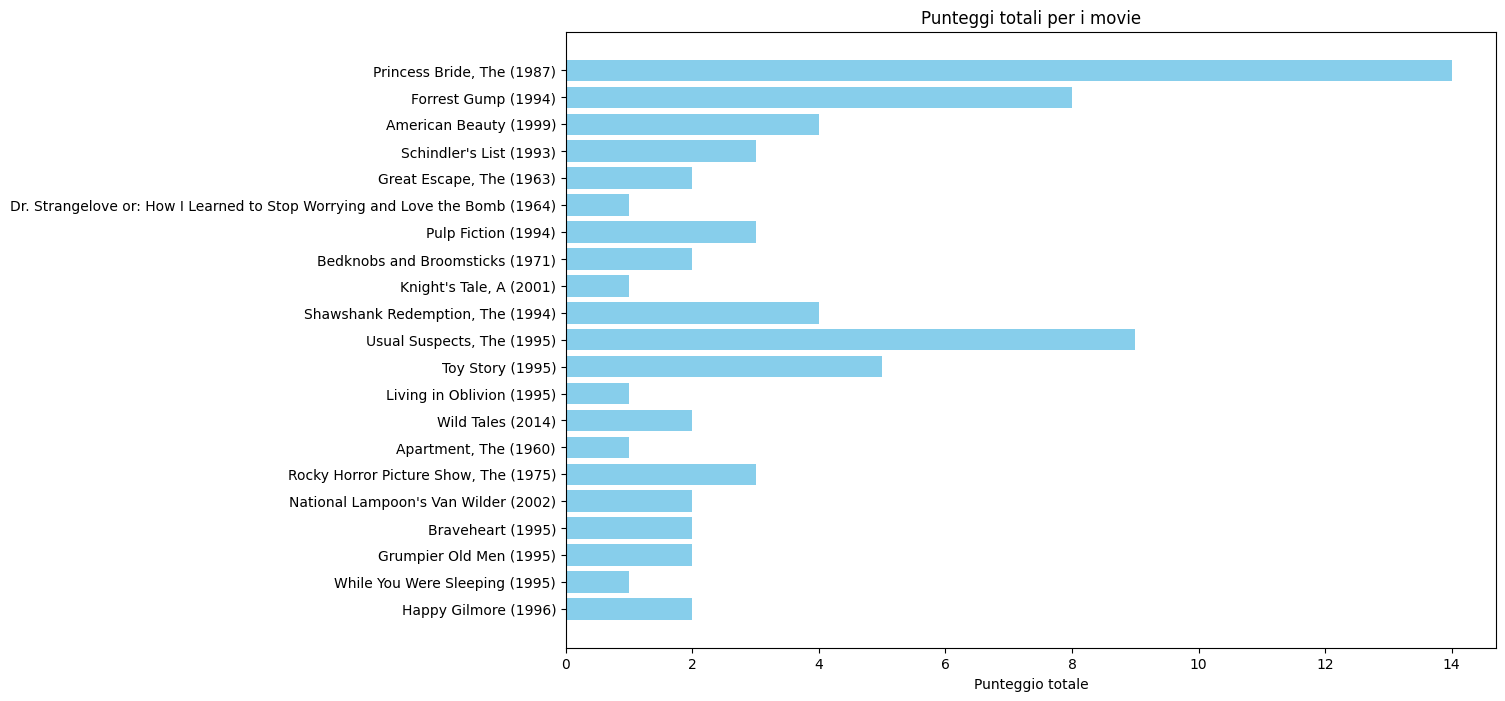

In [214]:
# Creare un grafico a barre
nomi = [info['nome'] for info in punteggi_totali.values()]
scores = [info['punteggio'] for info in punteggi_totali.values()]

plt.figure(figsize=(12, 8))
plt.barh(nomi, scores, color='skyblue')
plt.xlabel('Punteggio totale')
plt.title('Punteggi totali per i movie')
plt.gca().invert_yaxis()  # Inverti l'asse y per avere il punteggio più alto in alto
plt.show()


## Su df Normalizzato


In [215]:
# Associo il risultato al nome della strategia
nomi_funzioni_normalized = [
    ("Average Strategy", result1n),
    ("Average Without Misery Strategy", result2n),
    ("Least Misery Strategy", result3n),
    ("Most Pleasure Strategy", result4n),
    ("Additive Strategy", result5n),
    ("Multiplicative Strategy", result6n),
    ("Borda Count Strategy", result7n),
    ("Copeland Rule Strategy", result8n),
    ("Approval Voting Strategy", result9n),
    ("Dictatorship Strategy", result10n),
    ("Fairness Strategy", result11n),
    ("Plurality Voting Strategy", result12n)
]

# Chiamata della funzione confronta_liste con nomi delle funzioni
risultati_uguali_normalized = confronta_liste(*nomi_funzioni_normalized)

if risultati_uguali_normalized:
    for coppia in risultati_uguali_normalized:
        print(f"Le strategie {coppia[0]} e {coppia[1]} hanno risultati uguali.")
else:
    print("Nessuna coppia di funzioni ha risultato uguale.")


Le strategie Average Strategy e Additive Strategy hanno risultati uguali.


Funzione che assegna dei voti ai primi 3 item di ogni strategia, assegnando 3 punti al primo elemento, 2 al secondo e 3 al terzo. In modo da visualizzare i film con punteggi più alti

In [216]:
def calcola_punteggi(*args):
    punteggi_totali = {}

    for nome_norm, lista in args:
        for posizione, item_id in enumerate(lista[:3], start=1):
            if item_id not in punteggi_totali:
                punteggi_totali[item_id] = {'nome_norm': None, 'punteggio_norm': 0}

            # Assegna il nome solo una volta
            if punteggi_totali[item_id]['nome_norm'] is None:
                punteggi_totali[item_id]['nome_norm'] = get_titles_from_ids([item_id], movies)[0]

            # Assegna i punteggi
            punteggi_totali[item_id]['punteggio_norm'] += 4 - posizione

    return punteggi_totali

# Esempio di utilizzo con nomi delle funzioni e risultati
# Calcolo dei punteggi totali
punteggi_totali_normalized = calcola_punteggi(*nomi_funzioni_normalized)

# Stampa dei punteggi totali
for item_id, info in punteggi_totali_normalized.items():
    print(f"{info['nome_norm']}: Punteggio totale = {info['punteggio_norm']}")

Princess Bride, The (1987): Punteggio totale = 15
Forrest Gump (1994): Punteggio totale = 7
American Beauty (1999): Punteggio totale = 3
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964): Punteggio totale = 3
Casablanca (1942): Punteggio totale = 2
Streetcar Named Desire, A (1951): Punteggio totale = 1
Austin Powers: The Spy Who Shagged Me (1999): Punteggio totale = 3
Star Wars: Episode IV - A New Hope (1977): Punteggio totale = 2
LÃ©on: The Professional (a.k.a. The Professional) (LÃ©on) (1994): Punteggio totale = 1
Shawshank Redemption, The (1994): Punteggio totale = 4
Usual Suspects, The (1995): Punteggio totale = 10
Casino (1995): Punteggio totale = 2
Toy Story (1995): Punteggio totale = 1
Rear Window (1954): Punteggio totale = 3
Whiplash (2014): Punteggio totale = 2
Notorious (1946): Punteggio totale = 1
Ratatouille (2007): Punteggio totale = 3
Glory (1989): Punteggio totale = 2
Monty Python and the Holy Grail (1975): Punteggio totale = 1
Grumpier Old Men 

Grafico il risultato ottenuto mettendo sull'asse delle ascisse i punteggi di ogni filme e sull'asse delle ordinate il titolo

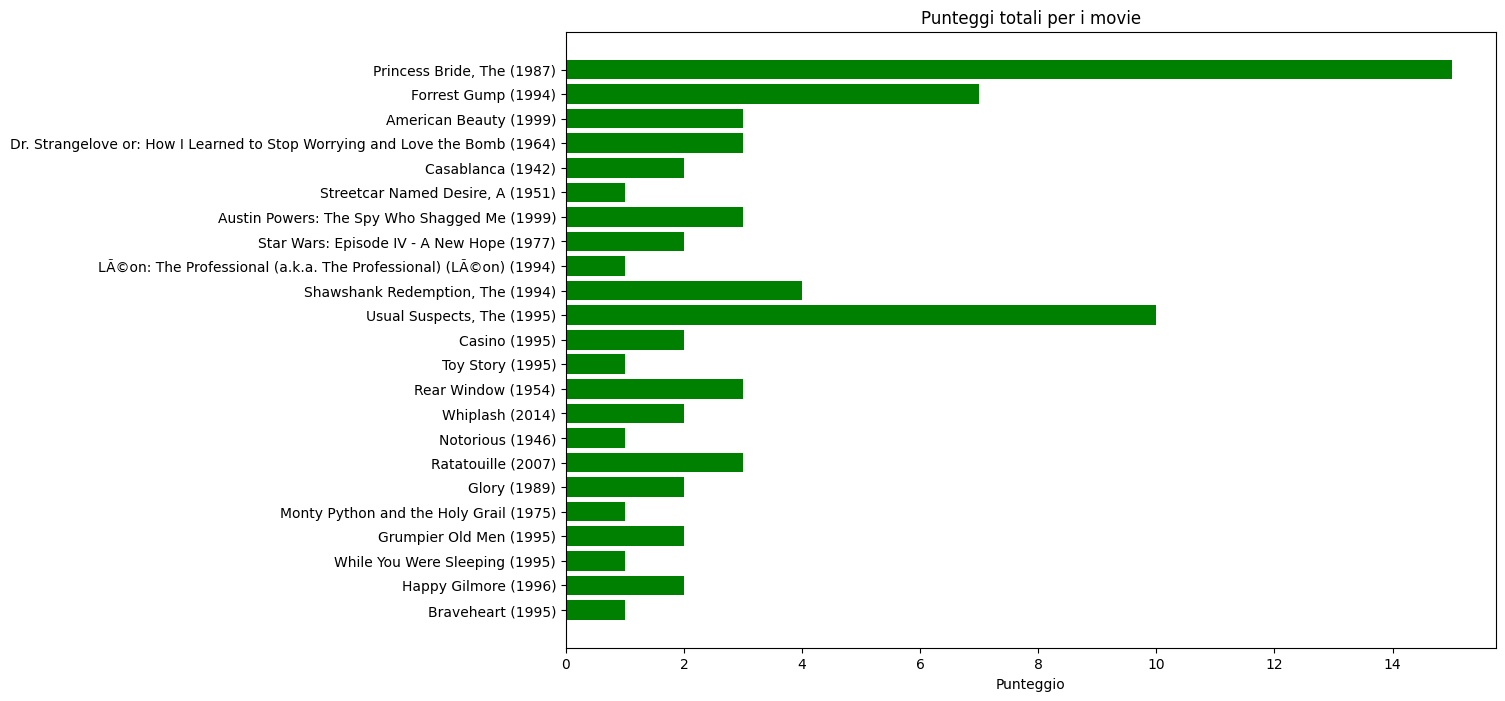

In [217]:
# Creare un grafico a barre
nomi_normalized = [info['nome_norm'] for info in punteggi_totali_normalized.values()]
scores_normalized = [info['punteggio_norm'] for info in punteggi_totali_normalized.values()]

plt.figure(figsize=(12, 8))
plt.barh(nomi_normalized, scores_normalized, color='green')
plt.xlabel('Punteggio')
plt.title('Punteggi totali per i movie')
plt.gca().invert_yaxis()  # Inverti l'asse y per avere il punteggio più alto in alto
plt.show()


Visualizzo le differenze tra i risultati ottenuti dalle strategie su df non normalizzato e su df normalizzato

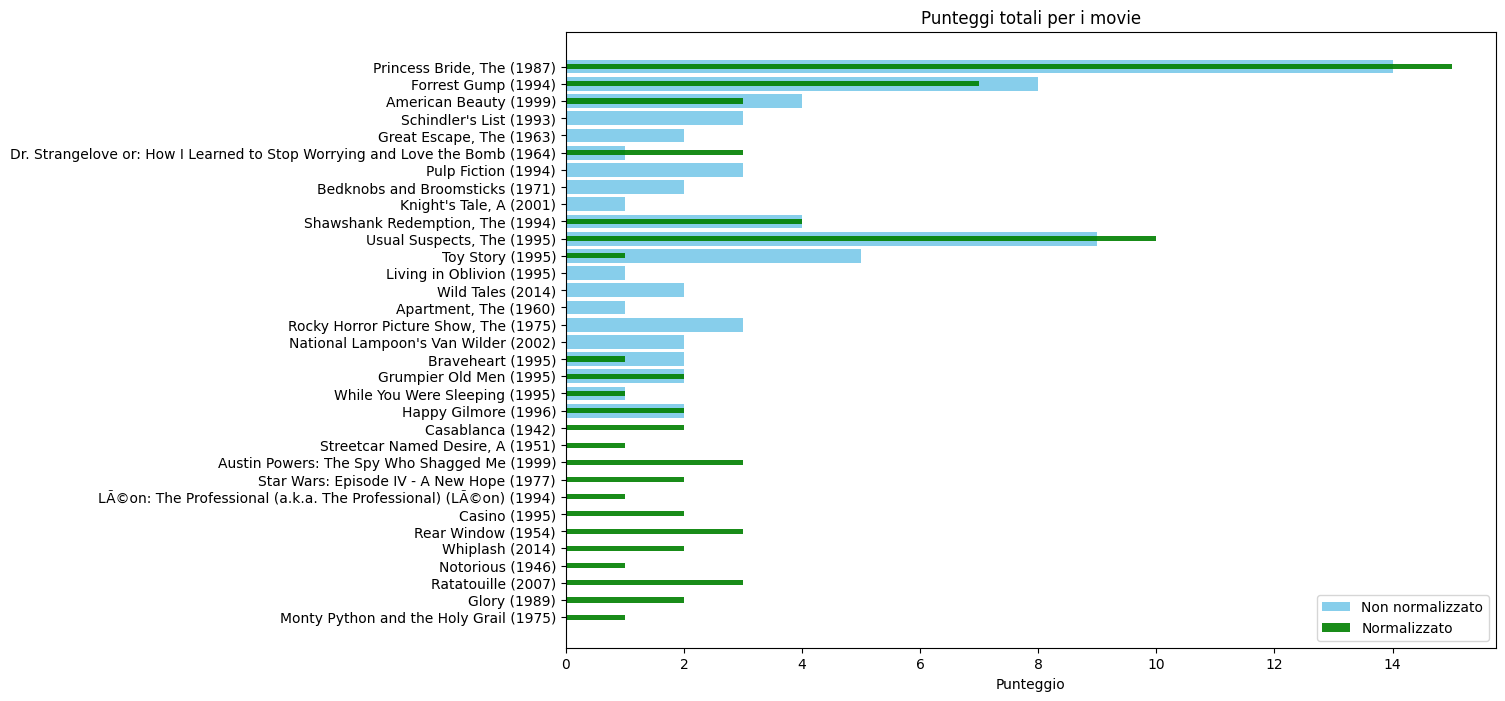

In [218]:
def plot_combined_scores_double_barh(punteggi_totali, punteggi_totali_normalized):
    # Estrai nomi e punteggi non normalizzati
    nomi = [info['nome'] for info in punteggi_totali.values()]
    scores = [info['punteggio'] for info in punteggi_totali.values()]

    # Estrai nomi e punteggi normalizzati
    nomi_normalized = [info['nome_norm'] for info in punteggi_totali_normalized.values()]
    scores_normalized = [info['punteggio_norm'] for info in punteggi_totali_normalized.values()]

    # Creare un grafico combinato
    plt.figure(figsize=(12, 8))

    # Barre blu per i punteggi non normalizzati
    plt.barh(nomi, scores, color='skyblue', label='Non normalizzato')

    # Barre verdi per i punteggi normalizzati su un piano più basso
    plt.barh(nomi_normalized, scores_normalized, color='green', alpha=0.9, label='Normalizzato', height=0.3)

    plt.xlabel('Punteggio')
    plt.title('Punteggi totali per i movie')
    plt.gca().invert_yaxis()  # Inverti l'asse y per avere il punteggio più alto in alto
    plt.legend()  # Aggiungi la legenda
    plt.show()

# Utilizzo della funzione
plot_combined_scores_double_barh(punteggi_totali, punteggi_totali_normalized)
